# Notebook 3: Model Training and Benchmarking

### Objectives:
1.  **Set up the Training Environment:** Configure hyperparameters, data loaders, models, and loss functions.
2.  **Train and Benchmark Models:** Train our three candidate models (`BaselineUNet`, `ResNetUNet`, `TransUNet`) on the processed dataset.
3.  **Evaluate Performance:** Analyze training progress with loss curves and evaluate final models on the unseen test set using the Dice score.
4.  **Visualize Results:** Create high-quality visualizations of model predictions for the final report and presentation.

## 1. Setup, Imports, and Path Definitions

We begin by importing all necessary libraries and defining the project's directory structure. This ensures our environment is correctly configured.

In [7]:
import os
import sys  # Import the sys module to manipulate Python's path
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from glob import glob
import random

# --- Define and Add Root Directory to Path ---
# This is the crucial step to fix the ModuleNotFoundError.
# When running a notebook from the 'notebooks' folder, we need to tell Python
# where to find our 'src' module in the parent directory.
ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))
if ROOT_DIR not in sys.path:
    sys.path.append(ROOT_DIR)
    print(f"Added Root Directory to Path: {ROOT_DIR}")

# --- Import custom models from src ---
# This will now work correctly
from src.models import BaselineUNet, ResNetUNet, TransUNet
print("Successfully imported custom models.")

# --- Define Project Directories ---
PROCESSED_DATA_DIR = os.path.join(ROOT_DIR, 'data', 'processed')
MODELS_DIR = os.path.join(ROOT_DIR, 'models')
FIGURES_DIR = os.path.join(ROOT_DIR, 'figures')

# Create directories if they don't exist
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(FIGURES_DIR, exist_ok=True)

print(f"Processed Data Directory: {PROCESSED_DATA_DIR}")
print(f"Saved Models Directory: {MODELS_DIR}")
print(f"Saved Figures Directory: {FIGURES_DIR}")

Successfully imported custom models.
Processed Data Directory: D:\Coding\GitHub\MRI-Tumor-Segmentation\data\processed
Saved Models Directory: D:\Coding\GitHub\MRI-Tumor-Segmentation\models
Saved Figures Directory: D:\Coding\GitHub\MRI-Tumor-Segmentation\figures


## 2. Configuration & Hyperparameters

This cell contains all the key parameters for our training run. To benchmark a different model, simply change the `MODEL_TO_TRAIN` variable and re-run the notebook.

In [8]:
# --- CONFIGURATION & HYPERPARAMETERS ---

# Choose which model to train: 'BaselineUNet', 'ResNetUNet', or 'TransUNet'
MODEL_TO_TRAIN = 'ResNetUNet'

# Data parameters
TEST_SPLIT_SIZE = 0.15
VALIDATION_SPLIT_SIZE = 0.15 # From the remaining data after test split
RANDOM_STATE = 42

# Training parameters
LEARNING_RATE = 1e-4
BATCH_SIZE = 16
NUM_EPOCHS = 100 # Start with a reasonable number, can be increased

# System parameters
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"DEVICE: {DEVICE}")
NUM_WORKERS = 0 # os.cpu_count()
PIN_MEMORY = True

# Ensure reproducibility
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_STATE)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

DEVICE: cuda


## 3. Custom PyTorch Dataset

We define a custom `Dataset` class. This is the standard PyTorch way to handle data. It loads data efficiently from disk slice by slice, which is essential for managing memory when working with large datasets.

In [9]:
import collections

class BrainMRIDataset(Dataset):
    def __init__(self, file_list, cache_size=6000): # Cache can hold 8000 items
        self.file_list = file_list
        self.cache_size = cache_size
        # Using an OrderedDict to implement a simple LRU (Least Recently Used) cache
        self.cache = collections.OrderedDict()
        
        print(f"Initialized dataset with {len(file_list)} files.")
        print(f"Cache size set to {cache_size} items.")

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        # --- Check if the item is in the cache ---
        if idx in self.cache:
            # Move the accessed item to the end to mark it as recently used
            self.cache.move_to_end(idx)
            return self.cache[idx]
        
        # --- If not in cache (cache miss), load from disk ---
        image_path = self.file_list[idx]
        mask_path = image_path.replace("_image.npy", "_mask.npy")
        
        image = np.load(image_path).astype(np.float32)
        mask = np.load(mask_path).astype(np.float32)

        image_tensor = torch.from_numpy(image).permute(2, 0, 1)
        mask_tensor = torch.from_numpy(mask).unsqueeze(0)
        
        # --- Manage cache size ---
        if len(self.cache) >= self.cache_size:
            # Pop the least recently used item (the first item in the dict)
            self.cache.popitem(last=False)
        
        # Add the newly loaded item to the cache
        self.cache[idx] = (image_tensor, mask_tensor)
        
        return image_tensor, mask_tensor

## 4. Data Splitting and Loaders

We split our list of processed slices into training, validation, and test sets. This is a critical step to ensure we can evaluate our model's generalization ability on unseen data. Then, we wrap these sets in `DataLoader` objects, which handle batching and shuffling automatically.

In [10]:
# Get all image file paths
all_files = glob(os.path.join(PROCESSED_DATA_DIR, "*_image.npy"))

# First, split into training+validation and test sets
train_val_files, test_files = train_test_split(
    all_files, test_size=TEST_SPLIT_SIZE, random_state=RANDOM_STATE
)

# Then, split the training+validation set into training and validation sets
relative_val_size = VALIDATION_SPLIT_SIZE / (1 - TEST_SPLIT_SIZE)
train_files, val_files = train_test_split(
    train_val_files, test_size=relative_val_size, random_state=RANDOM_STATE
)

# Create Dataset objects
train_dataset = BrainMRIDataset(train_files)
val_dataset = BrainMRIDataset(val_files)
test_dataset = BrainMRIDataset(test_files)

# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

# --- Print a summary of the data splitting ---
print("--- Data Splitting Summary ---")
print(f"Total slices: {len(all_files)}")
print(f"Training set:   {len(train_files)} slices ({len(train_files)/len(all_files):.1%})")
print(f"Validation set: {len(val_files)} slices ({len(val_files)/len(all_files):.1%})")
print(f"Test set:       {len(test_files)} slices ({len(test_files)/len(all_files):.1%})")
print("------------------------------")

Initialized dataset with 7484 files.
Cache size set to 6000 items.
Initialized dataset with 1604 files.
Cache size set to 6000 items.
Initialized dataset with 1604 files.
Cache size set to 6000 items.
--- Data Splitting Summary ---
Total slices: 10692
Training set:   7484 slices (70.0%)
Validation set: 1604 slices (15.0%)
Test set:       1604 slices (15.0%)
------------------------------


## 5. Loss Function and Evaluation Metric

We define our loss function, which is what the model tries to minimize. For segmentation, a combination of Binary Cross-Entropy (BCE) and Dice Loss is a powerful choice. 
- **BCE Loss:** Good for pixel-wise classification.
- **Dice Loss:** Directly optimizes the Dice coefficient, our main evaluation metric, which is excellent for handling class imbalance (more non-tumor pixels than tumor pixels).

In [11]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, y_pred, y_true):
        y_pred = y_pred.contiguous()
        y_true = y_true.contiguous()

        intersection = (y_pred * y_true).sum(dim=2).sum(dim=2)
        dice = (2. * intersection + self.smooth) / (y_pred.sum(dim=2).sum(dim=2) + y_true.sum(dim=2).sum(dim=2) + self.smooth)
        
        return 1 - dice.mean()

def dice_coefficient(y_pred, y_true, smooth=1e-6):
    y_pred = (y_pred > 0.5).float() # Binarize the prediction
    intersection = (y_pred * y_true).sum()
    dice = (2. * intersection + smooth) / (y_pred.sum() + y_true.sum() + smooth)
    return dice.item()

# Combined Loss Function
def combined_loss(y_pred, y_true):
    bce = nn.BCEWithLogitsLoss()(y_pred, y_true) # BCEWithLogitsLoss is more stable
    dice = DiceLoss()(torch.sigmoid(y_pred), y_true)
    return bce + dice

## 6. Training & Validation Loop

This is the core of our notebook. We define two functions:
1. `train_fn`: Handles one epoch of training. It iterates through the `train_loader`, performs forward and backward passes, and updates the model's weights.
2. `evaluate_fn`: Handles model evaluation on the validation or test set. It calculates the loss and Dice score without updating the model.

The main loop then orchestrates the training over multiple epochs, tracks performance, and saves the best model based on validation Dice score.

In [12]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader, desc="Training")
    running_loss = 0.0

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.to(device=DEVICE)

        # Forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # Backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())
    
    return running_loss / len(loader)

def evaluate_fn(loader, model, loss_fn, device):
    model.eval()
    loop = tqdm(loader, desc="Evaluating")
    val_loss = 0.0
    val_dice = 0.0

    with torch.no_grad():
        for data, targets in loop:
            data = data.to(device=device)
            targets = targets.to(device=device)
            
            predictions = model(data)
            loss = loss_fn(predictions, targets)
            val_loss += loss.item()
            
            # Calculate dice score
            preds_sigmoid = torch.sigmoid(predictions)
            dice = dice_coefficient(preds_sigmoid, targets)
            val_dice += dice
            loop.set_postfix(dice=dice)
            
    model.train()
    return val_loss / len(loader), val_dice / len(loader)

## 7. Run the Training

Now, we bring everything together. We select the model based on our configuration, initialize the optimizer, and start the main training loop. We will save the model with the best validation Dice score.

In [13]:
# ===================================================================================
#           MASTER BENCHMARKING AND TRAINING SCRIPT (FINAL ROBUST VERSION)
# This version uses model-specific configurations for both Learning Rate and Batch Size.
# ===================================================================================

import json
import gc # Garbage Collector interface

# --- 1. Define Model-Specific Configurations ---
MODEL_CONFIGS = {
    'ResNetUNet':   {'lr': 1e-4, 'batch_size': 16},
    'BaselineUNet': {'lr': 1e-4, 'batch_size': 16},
    'TransUNet':    {'lr': 1e-5, 'batch_size': 8}  # Smaller BS for memory-intensive model
}
models_to_benchmark = list(MODEL_CONFIGS.keys())
all_results = {}

# --- Print Overall Benchmarking Configuration ---
print("="*50)
print("     STARTING AUTOMATED MODEL BENCHMARKING")
print("="*50)
print(f"Models to train: {models_to_benchmark}")
print(f"Epochs per model: {NUM_EPOCHS}")
print(f"Device: {DEVICE}")
print("="*50)


# --- 2. Master Loop for Benchmarking ---
for model_name in models_to_benchmark:
    
    # --- Per-Model Setup ---
    print(f"\n\n--- Training Run Initiated for: {model_name} ---")
    
    # Clean up memory from previous run
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    if model_name == 'BaselineUNet':
        model = BaselineUNet(in_channels=4, out_channels=1).to(DEVICE)
    elif model_name == 'ResNetUNet':
        model = ResNetUNet(in_channels=4, out_channels=1).to(DEVICE)
    elif model_name == 'TransUNet':
        model = TransUNet(in_channels=4, out_channels=1).to(DEVICE)
    
    # Get model-specific configs
    config = MODEL_CONFIGS[model_name]
    learning_rate = config['lr']
    batch_size = config['batch_size']
    
    # Create new DataLoaders with the correct batch size for this model
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
    
    loss_fn = combined_loss
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE == "cuda"))

    history = {'train_loss': [], 'val_loss': [], 'val_dice': []}
    best_val_dice = -1.0
    model_save_path = os.path.join(MODELS_DIR, f'{model_name}_best_model.pth')

    print(f"Model '{model_name}' initialized. Config: LR={learning_rate}, Batch Size={batch_size}")
    print(f"Starting training for {NUM_EPOCHS} epochs...")
    print("--------------------------------------------------")

    # --- Main Training Loop for the current model ---
    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
        train_loss = train_fn(train_loader, model, optimizer, loss_fn, scaler)
        val_loss, val_dice = evaluate_fn(val_loader, model, loss_fn, DEVICE)
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Dice: {val_dice:.4f}")

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_dice'].append(val_dice)

        if val_dice > best_val_dice:
            print(f"Validation Dice improved from {best_val_dice:.4f} to {val_dice:.4f}. Saving model to {model_save_path}")
            best_val_dice = val_dice
            torch.save(model.state_dict(), model_save_path)

    print(f"\n--- Training Finished for {model_name} ---")

    # --- 3. Evaluate on Test Set and Store Results ---
    print(f"Loading best weights for {model_name} and evaluating on the test set...")
    model.load_state_dict(torch.load(model_save_path))
    test_loss, test_dice = evaluate_fn(test_loader, model, loss_fn, DEVICE)
    
    print(f"--- Final Test Performance for {model_name} ---")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Dice Score: {test_dice:.4f}")
    print("--------------------------------------------------")
    
    all_results[model_name] = {
        'history': history,
        'test_scores': {
            'loss': test_loss,
            'dice_score': test_dice
        },
        'config': config
    }

# --- 4. Save All Results to a Single JSON File ---
results_save_path = os.path.join(ROOT_DIR, 'results', 'all_model_results.json')
os.makedirs(os.path.dirname(results_save_path), exist_ok=True)

with open(results_save_path, 'w') as f:
    json.dump(all_results, f, indent=4)

print("\n\n" + "="*50)
print("     ALL BENCHMARKING RUNS COMPLETE")
print(f"All results saved to: {results_save_path}")
print("="*50)

     STARTING AUTOMATED MODEL BENCHMARKING
Models to train: ['ResNetUNet', 'BaselineUNet', 'TransUNet']
Epochs per model: 100
Device: cuda


--- Training Run Initiated for: ResNetUNet ---


C:\Users\ahmad\AppData\Local\Temp\ipykernel_10512\229460379.py:58: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE == "cuda"))


Model 'ResNetUNet' initialized. Config: LR=0.0001, Batch Size=16
Starting training for 100 epochs...
--------------------------------------------------

Epoch 1/100


Training:   0%|                                                                                                                          | 0/468 [00:00<?, ?it/s]C:\Users\ahmad\AppData\Local\Temp\ipykernel_10512\908607570.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:43<00:00,  1.62s/it, dice=0.126]


Train Loss: 1.5791 | Val Loss: 1.4846 | Val Dice: 0.1432
Validation Dice improved from -1.0000 to 0.1432. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\ResNetUNet_best_model.pth

Epoch 2/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:08<00:00, 11.97it/s, dice=0.126]


Train Loss: 1.4795 | Val Loss: 1.4693 | Val Dice: 0.1432

Epoch 3/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.24it/s, dice=0.126]


Train Loss: 1.4725 | Val Loss: 1.4670 | Val Dice: 0.1432

Epoch 4/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.03it/s, dice=0.126]


Train Loss: 1.4704 | Val Loss: 1.4651 | Val Dice: 0.1432

Epoch 5/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.43it/s, dice=0.126]


Train Loss: 1.4693 | Val Loss: 1.4642 | Val Dice: 0.1432

Epoch 6/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:08<00:00, 12.45it/s, dice=0.126]


Train Loss: 1.4686 | Val Loss: 1.4637 | Val Dice: 0.1432
Validation Dice improved from 0.1432 to 0.1432. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\ResNetUNet_best_model.pth

Epoch 7/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.14it/s, dice=0.126]


Train Loss: 1.4681 | Val Loss: 1.4634 | Val Dice: 0.1432
Validation Dice improved from 0.1432 to 0.1432. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\ResNetUNet_best_model.pth

Epoch 8/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.00it/s, dice=0.126]


Train Loss: 1.4677 | Val Loss: 1.4633 | Val Dice: 0.1432
Validation Dice improved from 0.1432 to 0.1432. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\ResNetUNet_best_model.pth

Epoch 9/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.35it/s, dice=0.126]


Train Loss: 1.4675 | Val Loss: 1.4629 | Val Dice: 0.1432
Validation Dice improved from 0.1432 to 0.1432. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\ResNetUNet_best_model.pth

Epoch 10/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.42it/s, dice=0.126]


Train Loss: 1.4673 | Val Loss: 1.4629 | Val Dice: 0.1433
Validation Dice improved from 0.1432 to 0.1433. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\ResNetUNet_best_model.pth

Epoch 11/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.40it/s, dice=0.126]


Train Loss: 1.4671 | Val Loss: 1.4627 | Val Dice: 0.1434
Validation Dice improved from 0.1433 to 0.1434. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\ResNetUNet_best_model.pth

Epoch 12/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.40it/s, dice=0.126]


Train Loss: 1.4670 | Val Loss: 1.4624 | Val Dice: 0.1435
Validation Dice improved from 0.1434 to 0.1435. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\ResNetUNet_best_model.pth

Epoch 13/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 12.93it/s, dice=0.126]


Train Loss: 1.4669 | Val Loss: 1.4623 | Val Dice: 0.1436
Validation Dice improved from 0.1435 to 0.1436. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\ResNetUNet_best_model.pth

Epoch 14/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.51it/s, dice=0.126]


Train Loss: 1.4668 | Val Loss: 1.4627 | Val Dice: 0.1438
Validation Dice improved from 0.1436 to 0.1438. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\ResNetUNet_best_model.pth

Epoch 15/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.24it/s, dice=0.126]


Train Loss: 1.4668 | Val Loss: 1.4623 | Val Dice: 0.1439
Validation Dice improved from 0.1438 to 0.1439. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\ResNetUNet_best_model.pth

Epoch 16/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.52it/s, dice=0.126]


Train Loss: 1.4666 | Val Loss: 1.4623 | Val Dice: 0.1441
Validation Dice improved from 0.1439 to 0.1441. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\ResNetUNet_best_model.pth

Epoch 17/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.54it/s, dice=0.126]


Train Loss: 1.4666 | Val Loss: 1.4622 | Val Dice: 0.1442
Validation Dice improved from 0.1441 to 0.1442. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\ResNetUNet_best_model.pth

Epoch 18/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.50it/s, dice=0.127]


Train Loss: 1.4665 | Val Loss: 1.4621 | Val Dice: 0.1450
Validation Dice improved from 0.1442 to 0.1450. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\ResNetUNet_best_model.pth

Epoch 19/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.22it/s, dice=0.127]


Train Loss: 1.4664 | Val Loss: 1.4622 | Val Dice: 0.1457
Validation Dice improved from 0.1450 to 0.1457. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\ResNetUNet_best_model.pth

Epoch 20/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.03it/s, dice=0.128]


Train Loss: 1.4664 | Val Loss: 1.4621 | Val Dice: 0.1463
Validation Dice improved from 0.1457 to 0.1463. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\ResNetUNet_best_model.pth

Epoch 21/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.24it/s, dice=0.128]


Train Loss: 1.4664 | Val Loss: 1.4620 | Val Dice: 0.1466
Validation Dice improved from 0.1463 to 0.1466. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\ResNetUNet_best_model.pth

Epoch 22/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.42it/s, dice=0.129]


Train Loss: 1.4663 | Val Loss: 1.4622 | Val Dice: 0.1491
Validation Dice improved from 0.1466 to 0.1491. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\ResNetUNet_best_model.pth

Epoch 23/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.20it/s, dice=0.131]


Train Loss: 1.4662 | Val Loss: 1.4619 | Val Dice: 0.1515
Validation Dice improved from 0.1491 to 0.1515. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\ResNetUNet_best_model.pth

Epoch 24/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.52it/s, dice=0.132]


Train Loss: 1.4663 | Val Loss: 1.4620 | Val Dice: 0.1537
Validation Dice improved from 0.1515 to 0.1537. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\ResNetUNet_best_model.pth

Epoch 25/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.50it/s, dice=0.135]


Train Loss: 1.4661 | Val Loss: 1.4621 | Val Dice: 0.1585
Validation Dice improved from 0.1537 to 0.1585. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\ResNetUNet_best_model.pth

Epoch 26/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.26it/s, dice=0.137]


Train Loss: 1.4661 | Val Loss: 1.4618 | Val Dice: 0.1602
Validation Dice improved from 0.1585 to 0.1602. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\ResNetUNet_best_model.pth

Epoch 27/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.53it/s, dice=0.142]


Train Loss: 1.4661 | Val Loss: 1.4619 | Val Dice: 0.1672
Validation Dice improved from 0.1602 to 0.1672. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\ResNetUNet_best_model.pth

Epoch 28/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.36it/s, dice=0.15]


Train Loss: 1.4661 | Val Loss: 1.4619 | Val Dice: 0.1796
Validation Dice improved from 0.1672 to 0.1796. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\ResNetUNet_best_model.pth

Epoch 29/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.53it/s, dice=0.158]


Train Loss: 1.4661 | Val Loss: 1.4620 | Val Dice: 0.1881
Validation Dice improved from 0.1796 to 0.1881. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\ResNetUNet_best_model.pth

Epoch 30/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.34it/s, dice=0.162]


Train Loss: 1.4660 | Val Loss: 1.4619 | Val Dice: 0.1960
Validation Dice improved from 0.1881 to 0.1960. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\ResNetUNet_best_model.pth

Epoch 31/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.50it/s, dice=0.166]


Train Loss: 1.4661 | Val Loss: 1.4619 | Val Dice: 0.1999
Validation Dice improved from 0.1960 to 0.1999. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\ResNetUNet_best_model.pth

Epoch 32/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.53it/s, dice=0.179]


Train Loss: 1.4660 | Val Loss: 1.4620 | Val Dice: 0.2189
Validation Dice improved from 0.1999 to 0.2189. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\ResNetUNet_best_model.pth

Epoch 33/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.55it/s, dice=0.213]


Train Loss: 1.4660 | Val Loss: 1.4618 | Val Dice: 0.2495
Validation Dice improved from 0.2189 to 0.2495. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\ResNetUNet_best_model.pth

Epoch 34/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 12.80it/s, dice=0.232]


Train Loss: 1.4660 | Val Loss: 1.4618 | Val Dice: 0.2780
Validation Dice improved from 0.2495 to 0.2780. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\ResNetUNet_best_model.pth

Epoch 35/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.47it/s, dice=0.318]


Train Loss: 1.4659 | Val Loss: 1.4617 | Val Dice: 0.3655
Validation Dice improved from 0.2780 to 0.3655. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\ResNetUNet_best_model.pth

Epoch 36/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.45it/s, dice=0.269]


Train Loss: 1.4659 | Val Loss: 1.4618 | Val Dice: 0.3318

Epoch 37/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.48it/s, dice=0.414]


Train Loss: 1.4659 | Val Loss: 1.4617 | Val Dice: 0.4986
Validation Dice improved from 0.3655 to 0.4986. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\ResNetUNet_best_model.pth

Epoch 38/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 12.70it/s, dice=0.428]


Train Loss: 1.4658 | Val Loss: 1.4619 | Val Dice: 0.5012
Validation Dice improved from 0.4986 to 0.5012. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\ResNetUNet_best_model.pth

Epoch 39/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.29it/s, dice=0.519]


Train Loss: 1.4659 | Val Loss: 1.4617 | Val Dice: 0.5868
Validation Dice improved from 0.5012 to 0.5868. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\ResNetUNet_best_model.pth

Epoch 40/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.47it/s, dice=0.667]


Train Loss: 1.4658 | Val Loss: 1.4617 | Val Dice: 0.7292
Validation Dice improved from 0.5868 to 0.7292. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\ResNetUNet_best_model.pth

Epoch 41/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.25it/s, dice=0.826]


Train Loss: 1.4658 | Val Loss: 1.4618 | Val Dice: 0.8764
Validation Dice improved from 0.7292 to 0.8764. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\ResNetUNet_best_model.pth

Epoch 42/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.44it/s, dice=0.48]


Train Loss: 1.4658 | Val Loss: 1.4616 | Val Dice: 0.5496

Epoch 43/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.15it/s, dice=0.535]


Train Loss: 1.4658 | Val Loss: 1.4617 | Val Dice: 0.6215

Epoch 44/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.41it/s, dice=0.767]


Train Loss: 1.4658 | Val Loss: 1.4618 | Val Dice: 0.8324

Epoch 45/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.43it/s, dice=0.519]


Train Loss: 1.4658 | Val Loss: 1.4617 | Val Dice: 0.5999

Epoch 46/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.60it/s, dice=1.13]


Train Loss: 1.4657 | Val Loss: 1.4617 | Val Dice: 1.1581
Validation Dice improved from 0.8764 to 1.1581. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\ResNetUNet_best_model.pth

Epoch 47/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.28it/s, dice=1.12]


Train Loss: 1.4658 | Val Loss: 1.4616 | Val Dice: 1.1743
Validation Dice improved from 1.1581 to 1.1743. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\ResNetUNet_best_model.pth

Epoch 48/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.55it/s, dice=0.987]


Train Loss: 1.4657 | Val Loss: 1.4618 | Val Dice: 1.0773

Epoch 49/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.54it/s, dice=0.794]


Train Loss: 1.4657 | Val Loss: 1.4617 | Val Dice: 0.8494

Epoch 50/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.48it/s, dice=0.975]


Train Loss: 1.4657 | Val Loss: 1.4619 | Val Dice: 1.0435

Epoch 51/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 12.85it/s, dice=1.12]


Train Loss: 1.4657 | Val Loss: 1.4616 | Val Dice: 1.1854
Validation Dice improved from 1.1743 to 1.1854. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\ResNetUNet_best_model.pth

Epoch 52/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.47it/s, dice=1.19]


Train Loss: 1.4657 | Val Loss: 1.4616 | Val Dice: 1.2246
Validation Dice improved from 1.1854 to 1.2246. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\ResNetUNet_best_model.pth

Epoch 53/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.51it/s, dice=1.18]


Train Loss: 1.4657 | Val Loss: 1.4616 | Val Dice: 1.2081

Epoch 54/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.45it/s, dice=1.16]


Train Loss: 1.4657 | Val Loss: 1.4616 | Val Dice: 1.1700

Epoch 55/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.12it/s, dice=1.26]


Train Loss: 1.4657 | Val Loss: 1.4616 | Val Dice: 1.2727
Validation Dice improved from 1.2246 to 1.2727. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\ResNetUNet_best_model.pth

Epoch 56/100


Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.46it/s, dice=1.2]


Train Loss: 1.4657 | Val Loss: 1.4616 | Val Dice: 1.2303

Epoch 57/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.42it/s, dice=1.27]


Train Loss: 1.4656 | Val Loss: 1.4617 | Val Dice: 1.2857
Validation Dice improved from 1.2727 to 1.2857. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\ResNetUNet_best_model.pth

Epoch 58/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.48it/s, dice=1.26]


Train Loss: 1.4656 | Val Loss: 1.4616 | Val Dice: 1.2798

Epoch 59/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.53it/s, dice=1.26]


Train Loss: 1.4656 | Val Loss: 1.4615 | Val Dice: 1.2829

Epoch 60/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 12.81it/s, dice=1.09]


Train Loss: 1.4656 | Val Loss: 1.4617 | Val Dice: 1.1365

Epoch 61/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.40it/s, dice=1.17]


Train Loss: 1.4656 | Val Loss: 1.4616 | Val Dice: 1.2136

Epoch 62/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.43it/s, dice=0.869]


Train Loss: 1.4656 | Val Loss: 1.4617 | Val Dice: 0.9357

Epoch 63/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.45it/s, dice=1.25]


Train Loss: 1.4656 | Val Loss: 1.4615 | Val Dice: 1.2758

Epoch 64/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.26it/s, dice=1.21]


Train Loss: 1.4656 | Val Loss: 1.4617 | Val Dice: 1.2297

Epoch 65/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.51it/s, dice=1.15]


Train Loss: 1.4655 | Val Loss: 1.4616 | Val Dice: 1.2051

Epoch 66/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.50it/s, dice=1.02]


Train Loss: 1.4655 | Val Loss: 1.4615 | Val Dice: 1.0817

Epoch 67/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.46it/s, dice=0.893]


Train Loss: 1.4655 | Val Loss: 1.4616 | Val Dice: 0.9732

Epoch 68/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.25it/s, dice=1.24]


Train Loss: 1.4655 | Val Loss: 1.4615 | Val Dice: 1.2557

Epoch 69/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.37it/s, dice=1.17]


Train Loss: 1.4655 | Val Loss: 1.4616 | Val Dice: 1.2242

Epoch 70/100


Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.48it/s, dice=1.2]


Train Loss: 1.4655 | Val Loss: 1.4616 | Val Dice: 1.2345

Epoch 71/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.47it/s, dice=1.16]


Train Loss: 1.4655 | Val Loss: 1.4615 | Val Dice: 1.2222

Epoch 72/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.02it/s, dice=1.22]


Train Loss: 1.4655 | Val Loss: 1.4616 | Val Dice: 1.2681

Epoch 73/100


Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.47it/s, dice=1.3]


Train Loss: 1.4654 | Val Loss: 1.4617 | Val Dice: 1.3223
Validation Dice improved from 1.2857 to 1.3223. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\ResNetUNet_best_model.pth

Epoch 74/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.50it/s, dice=1.02]


Train Loss: 1.4655 | Val Loss: 1.4617 | Val Dice: 1.0914

Epoch 75/100


Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.46it/s, dice=1.3]


Train Loss: 1.4655 | Val Loss: 1.4615 | Val Dice: 1.3178

Epoch 76/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.15it/s, dice=1.07]


Train Loss: 1.4654 | Val Loss: 1.4616 | Val Dice: 1.1294

Epoch 77/100


Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.38it/s, dice=1.2]


Train Loss: 1.4655 | Val Loss: 1.4615 | Val Dice: 1.2289

Epoch 78/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.44it/s, dice=1.27]


Train Loss: 1.4654 | Val Loss: 1.4616 | Val Dice: 1.2929

Epoch 79/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.46it/s, dice=1.19]


Train Loss: 1.4654 | Val Loss: 1.4615 | Val Dice: 1.1990

Epoch 80/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.45it/s, dice=1.29]


Train Loss: 1.4654 | Val Loss: 1.4617 | Val Dice: 1.3170

Epoch 81/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:08<00:00, 12.62it/s, dice=1.23]


Train Loss: 1.4654 | Val Loss: 1.4615 | Val Dice: 1.2570

Epoch 82/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.52it/s, dice=1.22]


Train Loss: 1.4654 | Val Loss: 1.4617 | Val Dice: 1.2626

Epoch 83/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.52it/s, dice=1.29]


Train Loss: 1.4654 | Val Loss: 1.4616 | Val Dice: 1.3051

Epoch 84/100


Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.56it/s, dice=1.3]


Train Loss: 1.4654 | Val Loss: 1.4616 | Val Dice: 1.3129

Epoch 85/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 12.77it/s, dice=1.26]


Train Loss: 1.4654 | Val Loss: 1.4616 | Val Dice: 1.2868

Epoch 86/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.53it/s, dice=1.25]


Train Loss: 1.4653 | Val Loss: 1.4617 | Val Dice: 1.2900

Epoch 87/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.54it/s, dice=1.28]


Train Loss: 1.4654 | Val Loss: 1.4616 | Val Dice: 1.3102

Epoch 88/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.49it/s, dice=1.23]


Train Loss: 1.4654 | Val Loss: 1.4615 | Val Dice: 1.2538

Epoch 89/100


Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 12.84it/s, dice=1.3]


Train Loss: 1.4653 | Val Loss: 1.4615 | Val Dice: 1.3193

Epoch 90/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.45it/s, dice=1.29]


Train Loss: 1.4654 | Val Loss: 1.4615 | Val Dice: 1.3091

Epoch 91/100


Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.48it/s, dice=1.3]


Train Loss: 1.4653 | Val Loss: 1.4616 | Val Dice: 1.3220

Epoch 92/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.43it/s, dice=1.31]


Train Loss: 1.4654 | Val Loss: 1.4617 | Val Dice: 1.3339
Validation Dice improved from 1.3223 to 1.3339. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\ResNetUNet_best_model.pth

Epoch 93/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.06it/s, dice=1.32]


Train Loss: 1.4654 | Val Loss: 1.4615 | Val Dice: 1.3303

Epoch 94/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.44it/s, dice=1.29]


Train Loss: 1.4654 | Val Loss: 1.4615 | Val Dice: 1.3041

Epoch 95/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.44it/s, dice=1.28]


Train Loss: 1.4654 | Val Loss: 1.4615 | Val Dice: 1.2989

Epoch 96/100


Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.44it/s, dice=1.3]


Train Loss: 1.4654 | Val Loss: 1.4617 | Val Dice: 1.3184

Epoch 97/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.48it/s, dice=1.18]


Train Loss: 1.4654 | Val Loss: 1.4615 | Val Dice: 1.2286

Epoch 98/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 12.86it/s, dice=1.27]


Train Loss: 1.4654 | Val Loss: 1.4615 | Val Dice: 1.2942

Epoch 99/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.35it/s, dice=1.27]


Train Loss: 1.4653 | Val Loss: 1.4615 | Val Dice: 1.2885

Epoch 100/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:07<00:00, 13.26it/s, dice=1.29]


Train Loss: 1.4653 | Val Loss: 1.4616 | Val Dice: 1.3109

--- Training Finished for ResNetUNet ---
Loading best weights for ResNetUNet and evaluating on the test set...


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [03:39<00:00,  2.17s/it, dice=1.35]


--- Final Test Performance for ResNetUNet ---
Test Loss: 1.4691
Test Dice Score: 1.3323
--------------------------------------------------


--- Training Run Initiated for: BaselineUNet ---
Model 'BaselineUNet' initialized. Config: LR=0.0001, Batch Size=16
Starting training for 100 epochs...
--------------------------------------------------

Epoch 1/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:26<00:00,  1.45s/it, dice=0.126]


Train Loss: 1.6100 | Val Loss: 1.5492 | Val Dice: 0.1432
Validation Dice improved from -1.0000 to 0.1432. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\BaselineUNet_best_model.pth

Epoch 2/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:07<00:00,  1.26s/it, dice=0.126]


Train Loss: 1.5331 | Val Loss: 1.5073 | Val Dice: 0.1432

Epoch 3/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:06<00:00,  1.26s/it, dice=0.126]


Train Loss: 1.5038 | Val Loss: 1.4935 | Val Dice: 0.1432

Epoch 4/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:06<00:00,  1.25s/it, dice=0.126]


Train Loss: 1.4898 | Val Loss: 1.4806 | Val Dice: 0.1432

Epoch 5/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:07<00:00,  1.26s/it, dice=0.126]


Train Loss: 1.4826 | Val Loss: 1.4743 | Val Dice: 0.1432

Epoch 6/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:07<00:00,  1.26s/it, dice=0.126]


Train Loss: 1.4779 | Val Loss: 1.4726 | Val Dice: 0.1432

Epoch 7/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:07<00:00,  1.26s/it, dice=0.126]


Train Loss: 1.4754 | Val Loss: 1.4694 | Val Dice: 0.1432

Epoch 8/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:08<00:00,  1.27s/it, dice=0.126]


Train Loss: 1.4735 | Val Loss: 1.4674 | Val Dice: 0.1432

Epoch 9/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:07<00:00,  1.26s/it, dice=0.126]


Train Loss: 1.4725 | Val Loss: 1.4670 | Val Dice: 0.1432

Epoch 10/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:07<00:00,  1.26s/it, dice=0.126]


Train Loss: 1.4714 | Val Loss: 1.4658 | Val Dice: 0.1432

Epoch 11/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:08<00:00,  1.27s/it, dice=0.126]


Train Loss: 1.4705 | Val Loss: 1.4657 | Val Dice: 0.1432

Epoch 12/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:08<00:00,  1.27s/it, dice=0.126]


Train Loss: 1.4698 | Val Loss: 1.4650 | Val Dice: 0.1432

Epoch 13/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:07<00:00,  1.27s/it, dice=0.126]


Train Loss: 1.4695 | Val Loss: 1.4644 | Val Dice: 0.1432

Epoch 14/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:07<00:00,  1.26s/it, dice=0.126]


Train Loss: 1.4691 | Val Loss: 1.4652 | Val Dice: 0.1432

Epoch 15/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:07<00:00,  1.27s/it, dice=0.126]


Train Loss: 1.4692 | Val Loss: 1.4644 | Val Dice: 0.1432

Epoch 16/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:08<00:00,  1.27s/it, dice=0.126]


Train Loss: 1.4685 | Val Loss: 1.4635 | Val Dice: 0.1432

Epoch 17/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:56<00:00,  1.74s/it, dice=0.126]


Train Loss: 1.4683 | Val Loss: 1.4636 | Val Dice: 0.1432
Validation Dice improved from 0.1432 to 0.1432. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\BaselineUNet_best_model.pth

Epoch 18/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [03:12<00:00,  1.91s/it, dice=0.126]


Train Loss: 1.4680 | Val Loss: 1.4633 | Val Dice: 0.1432
Validation Dice improved from 0.1432 to 0.1432. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\BaselineUNet_best_model.pth

Epoch 19/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:34<00:00,  1.53s/it, dice=0.126]


Train Loss: 1.4680 | Val Loss: 1.4633 | Val Dice: 0.1432
Validation Dice improved from 0.1432 to 0.1432. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\BaselineUNet_best_model.pth

Epoch 20/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:34<00:00,  1.53s/it, dice=0.126]


Train Loss: 1.4678 | Val Loss: 1.4629 | Val Dice: 0.1432

Epoch 21/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:31<00:00,  1.50s/it, dice=0.126]


Train Loss: 1.4677 | Val Loss: 1.4631 | Val Dice: 0.1432
Validation Dice improved from 0.1432 to 0.1432. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\BaselineUNet_best_model.pth

Epoch 22/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:31<00:00,  1.50s/it, dice=0.126]


Train Loss: 1.4677 | Val Loss: 1.4629 | Val Dice: 0.1432
Validation Dice improved from 0.1432 to 0.1432. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\BaselineUNet_best_model.pth

Epoch 23/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:28<00:00,  1.47s/it, dice=0.126]


Train Loss: 1.4678 | Val Loss: 1.4629 | Val Dice: 0.1432
Validation Dice improved from 0.1432 to 0.1432. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\BaselineUNet_best_model.pth

Epoch 24/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:29<00:00,  1.48s/it, dice=0.126]


Train Loss: 1.4674 | Val Loss: 1.4630 | Val Dice: 0.1432

Epoch 25/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:30<00:00,  1.49s/it, dice=0.126]


Train Loss: 1.4672 | Val Loss: 1.4628 | Val Dice: 0.1432
Validation Dice improved from 0.1432 to 0.1432. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\BaselineUNet_best_model.pth

Epoch 26/100


Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:30<00:00,  1.49s/it, dice=0.126]


Train Loss: 1.4672 | Val Loss: 1.4627 | Val Dice: 0.1433
Validation Dice improved from 0.1432 to 0.1433. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\BaselineUNet_best_model.pth

Epoch 27/100


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [13:03<00:00,  1.67s/it, loss=1.5]
Evaluating: 100%|█| 101/101 [02:30


Train Loss: 1.4672 | Val Loss: 1.4625 | Val Dice: 0.1433
Validation Dice improved from 0.1433 to 0.1433. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\BaselineUNet_best_model.pth

Epoch 28/100


Training: 100%|█| 468/468 [11:33<0
Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:38<00:00,  1.57s/it, dice=0.126]


Train Loss: 1.4672 | Val Loss: 1.4625 | Val Dice: 0.1433
Validation Dice improved from 0.1433 to 0.1433. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\BaselineUNet_best_model.pth

Epoch 29/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:43<00:00,  1.61s/it, dice=0.126]


Train Loss: 1.4669 | Val Loss: 1.4624 | Val Dice: 0.1433
Validation Dice improved from 0.1433 to 0.1433. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\BaselineUNet_best_model.pth

Epoch 30/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:36<00:00,  1.55s/it, dice=0.126]


Train Loss: 1.4672 | Val Loss: 1.4624 | Val Dice: 0.1434
Validation Dice improved from 0.1433 to 0.1434. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\BaselineUNet_best_model.pth

Epoch 31/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:32<00:00,  1.51s/it, dice=0.126]


Train Loss: 1.4669 | Val Loss: 1.4622 | Val Dice: 0.1434

Epoch 32/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:30<00:00,  1.49s/it, dice=0.126]


Train Loss: 1.4668 | Val Loss: 1.4623 | Val Dice: 0.1435
Validation Dice improved from 0.1434 to 0.1435. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\BaselineUNet_best_model.pth

Epoch 33/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:30<00:00,  1.49s/it, dice=0.126]


Train Loss: 1.4668 | Val Loss: 1.4623 | Val Dice: 0.1436
Validation Dice improved from 0.1435 to 0.1436. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\BaselineUNet_best_model.pth

Epoch 34/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:32<00:00,  1.51s/it, dice=0.126]


Train Loss: 1.4668 | Val Loss: 1.4624 | Val Dice: 0.1436

Epoch 35/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:34<00:00,  1.53s/it, dice=0.126]


Train Loss: 1.4667 | Val Loss: 1.4623 | Val Dice: 0.1441
Validation Dice improved from 0.1436 to 0.1441. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\BaselineUNet_best_model.pth

Epoch 36/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:28<00:00,  1.47s/it, dice=0.126]


Train Loss: 1.4667 | Val Loss: 1.4623 | Val Dice: 0.1441
Validation Dice improved from 0.1441 to 0.1441. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\BaselineUNet_best_model.pth

Epoch 37/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:33<00:00,  1.52s/it, dice=0.127]


Train Loss: 1.4666 | Val Loss: 1.4624 | Val Dice: 0.1445
Validation Dice improved from 0.1441 to 0.1445. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\BaselineUNet_best_model.pth

Epoch 38/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:32<00:00,  1.51s/it, dice=0.127]


Train Loss: 1.4666 | Val Loss: 1.4620 | Val Dice: 0.1446
Validation Dice improved from 0.1445 to 0.1446. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\BaselineUNet_best_model.pth

Epoch 39/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:29<00:00,  1.48s/it, dice=0.128]


Train Loss: 1.4665 | Val Loss: 1.4622 | Val Dice: 0.1459
Validation Dice improved from 0.1446 to 0.1459. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\BaselineUNet_best_model.pth

Epoch 40/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:30<00:00,  1.49s/it, dice=0.132]


Train Loss: 1.4666 | Val Loss: 1.4623 | Val Dice: 0.1511
Validation Dice improved from 0.1459 to 0.1511. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\BaselineUNet_best_model.pth

Epoch 41/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:29<00:00,  1.48s/it, dice=0.129]


Train Loss: 1.4665 | Val Loss: 1.4622 | Val Dice: 0.1484

Epoch 42/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:31<00:00,  1.50s/it, dice=0.133]


Train Loss: 1.4665 | Val Loss: 1.4621 | Val Dice: 0.1537
Validation Dice improved from 0.1511 to 0.1537. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\BaselineUNet_best_model.pth

Epoch 43/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:30<00:00,  1.49s/it, dice=0.131]


Train Loss: 1.4664 | Val Loss: 1.4619 | Val Dice: 0.1509

Epoch 44/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:30<00:00,  1.49s/it, dice=0.137]


Train Loss: 1.4663 | Val Loss: 1.4620 | Val Dice: 0.1569
Validation Dice improved from 0.1537 to 0.1569. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\BaselineUNet_best_model.pth

Epoch 45/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:29<00:00,  1.48s/it, dice=0.138]


Train Loss: 1.4664 | Val Loss: 1.4620 | Val Dice: 0.1587
Validation Dice improved from 0.1569 to 0.1587. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\BaselineUNet_best_model.pth

Epoch 46/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:30<00:00,  1.49s/it, dice=0.144]


Train Loss: 1.4664 | Val Loss: 1.4618 | Val Dice: 0.1665
Validation Dice improved from 0.1587 to 0.1665. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\BaselineUNet_best_model.pth

Epoch 47/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:30<00:00,  1.49s/it, dice=0.151]


Train Loss: 1.4663 | Val Loss: 1.4619 | Val Dice: 0.1742
Validation Dice improved from 0.1665 to 0.1742. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\BaselineUNet_best_model.pth

Epoch 48/100


Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:36<00:00,  1.55s/it, dice=0.16]


Train Loss: 1.4663 | Val Loss: 1.4618 | Val Dice: 0.1862
Validation Dice improved from 0.1742 to 0.1862. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\BaselineUNet_best_model.pth

Epoch 49/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:29<00:00,  1.48s/it, dice=0.149]


Train Loss: 1.4663 | Val Loss: 1.4622 | Val Dice: 0.1721

Epoch 50/100


Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:31<00:00,  1.50s/it, dice=0.16]


Train Loss: 1.4663 | Val Loss: 1.4618 | Val Dice: 0.1846

Epoch 51/100


Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:32<00:00,  1.51s/it, dice=0.19]


Train Loss: 1.4662 | Val Loss: 1.4618 | Val Dice: 0.2209
Validation Dice improved from 0.1862 to 0.2209. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\BaselineUNet_best_model.pth

Epoch 52/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:30<00:00,  1.49s/it, dice=0.176]


Train Loss: 1.4662 | Val Loss: 1.4618 | Val Dice: 0.2061

Epoch 53/100


Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:32<00:00,  1.51s/it, dice=0.2]


Train Loss: 1.4662 | Val Loss: 1.4619 | Val Dice: 0.2356
Validation Dice improved from 0.2209 to 0.2356. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\BaselineUNet_best_model.pth

Epoch 54/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:29<00:00,  1.48s/it, dice=0.199]


Train Loss: 1.4662 | Val Loss: 1.4618 | Val Dice: 0.2398
Validation Dice improved from 0.2356 to 0.2398. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\BaselineUNet_best_model.pth

Epoch 55/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:30<00:00,  1.49s/it, dice=0.242]


Train Loss: 1.4662 | Val Loss: 1.4619 | Val Dice: 0.2934
Validation Dice improved from 0.2398 to 0.2934. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\BaselineUNet_best_model.pth

Epoch 56/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:39<00:00,  1.58s/it, dice=0.227]


Train Loss: 1.4662 | Val Loss: 1.4618 | Val Dice: 0.2629

Epoch 57/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:35<00:00,  1.54s/it, dice=0.256]


Train Loss: 1.4661 | Val Loss: 1.4617 | Val Dice: 0.3032
Validation Dice improved from 0.2934 to 0.3032. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\BaselineUNet_best_model.pth

Epoch 58/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:33<00:00,  1.52s/it, dice=0.217]


Train Loss: 1.4660 | Val Loss: 1.4620 | Val Dice: 0.2547

Epoch 59/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:29<00:00,  1.48s/it, dice=0.242]


Train Loss: 1.4661 | Val Loss: 1.4617 | Val Dice: 0.2886

Epoch 60/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:29<00:00,  1.48s/it, dice=0.273]


Train Loss: 1.4661 | Val Loss: 1.4617 | Val Dice: 0.3233
Validation Dice improved from 0.3032 to 0.3233. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\BaselineUNet_best_model.pth

Epoch 61/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:30<00:00,  1.49s/it, dice=0.216]


Train Loss: 1.4660 | Val Loss: 1.4617 | Val Dice: 0.2633

Epoch 62/100


Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:35<00:00,  1.54s/it, dice=0.31]


Train Loss: 1.4660 | Val Loss: 1.4617 | Val Dice: 0.3732
Validation Dice improved from 0.3233 to 0.3732. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\BaselineUNet_best_model.pth

Epoch 63/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:36<00:00,  1.55s/it, dice=0.407]


Train Loss: 1.4660 | Val Loss: 1.4617 | Val Dice: 0.4331
Validation Dice improved from 0.3732 to 0.4331. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\BaselineUNet_best_model.pth

Epoch 64/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:37<00:00,  1.56s/it, dice=0.249]


Train Loss: 1.4660 | Val Loss: 1.4616 | Val Dice: 0.3041

Epoch 65/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:38<00:00,  1.57s/it, dice=0.279]


Train Loss: 1.4660 | Val Loss: 1.4616 | Val Dice: 0.3230

Epoch 66/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:30<00:00,  1.49s/it, dice=0.411]


Train Loss: 1.4660 | Val Loss: 1.4617 | Val Dice: 0.4784
Validation Dice improved from 0.4331 to 0.4784. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\BaselineUNet_best_model.pth

Epoch 67/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:31<00:00,  1.50s/it, dice=0.324]


Train Loss: 1.4659 | Val Loss: 1.4617 | Val Dice: 0.3918

Epoch 68/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:31<00:00,  1.50s/it, dice=0.794]


Train Loss: 1.4659 | Val Loss: 1.4616 | Val Dice: 0.7982
Validation Dice improved from 0.4784 to 0.7982. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\BaselineUNet_best_model.pth

Epoch 69/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:30<00:00,  1.49s/it, dice=0.532]


Train Loss: 1.4659 | Val Loss: 1.4616 | Val Dice: 0.5903

Epoch 70/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:29<00:00,  1.48s/it, dice=0.409]


Train Loss: 1.4659 | Val Loss: 1.4616 | Val Dice: 0.5063

Epoch 71/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:34<00:00,  1.53s/it, dice=0.679]


Train Loss: 1.4659 | Val Loss: 1.4616 | Val Dice: 0.6877

Epoch 72/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:28<00:00,  1.47s/it, dice=0.292]


Train Loss: 1.4659 | Val Loss: 1.4617 | Val Dice: 0.3693

Epoch 73/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:34<00:00,  1.53s/it, dice=0.252]


Train Loss: 1.4659 | Val Loss: 1.4621 | Val Dice: 0.3097

Epoch 74/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:32<00:00,  1.51s/it, dice=0.407]


Train Loss: 1.4659 | Val Loss: 1.4616 | Val Dice: 0.4770

Epoch 75/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:32<00:00,  1.51s/it, dice=0.277]


Train Loss: 1.4659 | Val Loss: 1.4616 | Val Dice: 0.3429

Epoch 76/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:30<00:00,  1.49s/it, dice=0.329]


Train Loss: 1.4659 | Val Loss: 1.4617 | Val Dice: 0.4093

Epoch 77/100


Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:37<00:00,  1.56s/it, dice=0.73]


Train Loss: 1.4658 | Val Loss: 1.4615 | Val Dice: 0.7910

Epoch 78/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:31<00:00,  1.50s/it, dice=0.428]


Train Loss: 1.4658 | Val Loss: 1.4616 | Val Dice: 0.5085

Epoch 79/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:32<00:00,  1.51s/it, dice=0.346]


Train Loss: 1.4658 | Val Loss: 1.4616 | Val Dice: 0.4292

Epoch 80/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:33<00:00,  1.52s/it, dice=0.383]


Train Loss: 1.4658 | Val Loss: 1.4617 | Val Dice: 0.4527

Epoch 81/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:32<00:00,  1.51s/it, dice=0.806]


Train Loss: 1.4657 | Val Loss: 1.4615 | Val Dice: 0.8610
Validation Dice improved from 0.7982 to 0.8610. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\BaselineUNet_best_model.pth

Epoch 82/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:33<00:00,  1.52s/it, dice=0.537]


Train Loss: 1.4657 | Val Loss: 1.4615 | Val Dice: 0.6254

Epoch 83/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:37<00:00,  1.56s/it, dice=0.365]


Train Loss: 1.4657 | Val Loss: 1.4616 | Val Dice: 0.4540

Epoch 84/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:37<00:00,  1.56s/it, dice=0.652]


Train Loss: 1.4657 | Val Loss: 1.4616 | Val Dice: 0.7135

Epoch 85/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:31<00:00,  1.50s/it, dice=0.398]


Train Loss: 1.4657 | Val Loss: 1.4615 | Val Dice: 0.4843

Epoch 86/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:35<00:00,  1.54s/it, dice=0.318]


Train Loss: 1.4657 | Val Loss: 1.4615 | Val Dice: 0.3988

Epoch 87/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:36<00:00,  1.55s/it, dice=0.487]


Train Loss: 1.4657 | Val Loss: 1.4615 | Val Dice: 0.5953

Epoch 88/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:33<00:00,  1.52s/it, dice=0.545]


Train Loss: 1.4657 | Val Loss: 1.4615 | Val Dice: 0.6370

Epoch 89/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [03:30<00:00,  2.08s/it, dice=0.383]


Train Loss: 1.4657 | Val Loss: 1.4615 | Val Dice: 0.4610

Epoch 90/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [03:18<00:00,  1.97s/it, dice=0.339]


Train Loss: 1.4657 | Val Loss: 1.4616 | Val Dice: 0.4254

Epoch 91/100


Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:44<00:00,  1.63s/it, dice=0.76]


Train Loss: 1.4657 | Val Loss: 1.4616 | Val Dice: 0.8416

Epoch 92/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:33<00:00,  1.52s/it, dice=0.438]


Train Loss: 1.4657 | Val Loss: 1.4618 | Val Dice: 0.5167

Epoch 93/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:35<00:00,  1.53s/it, dice=0.777]


Train Loss: 1.4656 | Val Loss: 1.4616 | Val Dice: 0.8336

Epoch 94/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:31<00:00,  1.50s/it, dice=0.448]


Train Loss: 1.4656 | Val Loss: 1.4615 | Val Dice: 0.5480

Epoch 95/100


Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:33<00:00,  1.52s/it, dice=0.43]


Train Loss: 1.4656 | Val Loss: 1.4615 | Val Dice: 0.5221

Epoch 96/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:35<00:00,  1.54s/it, dice=0.771]


Train Loss: 1.4656 | Val Loss: 1.4615 | Val Dice: 0.8440

Epoch 97/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:36<00:00,  1.55s/it, dice=0.405]


Train Loss: 1.4656 | Val Loss: 1.4615 | Val Dice: 0.4793

Epoch 98/100


Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:32<00:00,  1.51s/it, dice=0.62]


Train Loss: 1.4656 | Val Loss: 1.4615 | Val Dice: 0.7040

Epoch 99/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:32<00:00,  1.51s/it, dice=0.566]


Train Loss: 1.4656 | Val Loss: 1.4615 | Val Dice: 0.6681

Epoch 100/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [02:29<00:00,  1.48s/it, dice=0.418]


Train Loss: 1.4656 | Val Loss: 1.4616 | Val Dice: 0.4994

--- Training Finished for BaselineUNet ---
Loading best weights for BaselineUNet and evaluating on the test set...


Evaluating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [03:17<00:00,  1.95s/it, dice=0.89]


--- Final Test Performance for BaselineUNet ---
Test Loss: 1.4690
Test Dice Score: 0.8488
--------------------------------------------------


--- Training Run Initiated for: TransUNet ---
Model 'TransUNet' initialized. Config: LR=1e-05, Batch Size=8
Starting training for 100 epochs...
--------------------------------------------------

Epoch 1/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:15<00:00, 12.64it/s, dice=0.126]


Train Loss: 1.6796 | Val Loss: 1.6414 | Val Dice: 0.1429
Validation Dice improved from -1.0000 to 0.1429. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\TransUNet_best_model.pth

Epoch 2/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.73it/s, dice=0.126]


Train Loss: 1.6364 | Val Loss: 1.6214 | Val Dice: 0.1429

Epoch 3/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.46it/s, dice=0.126]


Train Loss: 1.6193 | Val Loss: 1.6102 | Val Dice: 0.1429

Epoch 4/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.52it/s, dice=0.126]


Train Loss: 1.6053 | Val Loss: 1.5932 | Val Dice: 0.1429

Epoch 5/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:15<00:00, 13.04it/s, dice=0.126]


Train Loss: 1.5925 | Val Loss: 1.5826 | Val Dice: 0.1429

Epoch 6/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:18<00:00, 10.96it/s, dice=0.126]


Train Loss: 1.5806 | Val Loss: 1.5703 | Val Dice: 0.1429

Epoch 7/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:15<00:00, 13.38it/s, dice=0.126]


Train Loss: 1.5696 | Val Loss: 1.5606 | Val Dice: 0.1429

Epoch 8/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.41it/s, dice=0.126]


Train Loss: 1.5597 | Val Loss: 1.5495 | Val Dice: 0.1429

Epoch 9/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:15<00:00, 12.59it/s, dice=0.126]


Train Loss: 1.5503 | Val Loss: 1.5417 | Val Dice: 0.1429

Epoch 10/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.61it/s, dice=0.126]


Train Loss: 1.5419 | Val Loss: 1.5325 | Val Dice: 0.1429

Epoch 11/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.78it/s, dice=0.126]


Train Loss: 1.5340 | Val Loss: 1.5268 | Val Dice: 0.1429

Epoch 12/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:15<00:00, 13.14it/s, dice=0.126]


Train Loss: 1.5269 | Val Loss: 1.5195 | Val Dice: 0.1429

Epoch 13/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.69it/s, dice=0.126]


Train Loss: 1.5205 | Val Loss: 1.5132 | Val Dice: 0.1429

Epoch 14/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:16<00:00, 12.40it/s, dice=0.126]


Train Loss: 1.5145 | Val Loss: 1.5074 | Val Dice: 0.1429

Epoch 15/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.73it/s, dice=0.126]


Train Loss: 1.5092 | Val Loss: 1.5027 | Val Dice: 0.1429

Epoch 16/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.61it/s, dice=0.126]


Train Loss: 1.5043 | Val Loss: 1.4970 | Val Dice: 0.1429

Epoch 17/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.87it/s, dice=0.126]


Train Loss: 1.5002 | Val Loss: 1.4947 | Val Dice: 0.1429

Epoch 18/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:15<00:00, 12.92it/s, dice=0.126]


Train Loss: 1.4962 | Val Loss: 1.4899 | Val Dice: 0.1429

Epoch 19/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.82it/s, dice=0.126]


Train Loss: 1.4928 | Val Loss: 1.4870 | Val Dice: 0.1429

Epoch 20/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.40it/s, dice=0.126]


Train Loss: 1.4898 | Val Loss: 1.4836 | Val Dice: 0.1429

Epoch 21/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.89it/s, dice=0.126]


Train Loss: 1.4870 | Val Loss: 1.4817 | Val Dice: 0.1429

Epoch 22/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:16<00:00, 12.51it/s, dice=0.126]


Train Loss: 1.4847 | Val Loss: 1.4800 | Val Dice: 0.1429

Epoch 23/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.77it/s, dice=0.126]


Train Loss: 1.4825 | Val Loss: 1.4774 | Val Dice: 0.1429

Epoch 24/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.90it/s, dice=0.126]


Train Loss: 1.4807 | Val Loss: 1.4752 | Val Dice: 0.1429

Epoch 25/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:15<00:00, 13.28it/s, dice=0.126]


Train Loss: 1.4790 | Val Loss: 1.4739 | Val Dice: 0.1429

Epoch 26/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.61it/s, dice=0.126]


Train Loss: 1.4776 | Val Loss: 1.4725 | Val Dice: 0.1429

Epoch 27/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.44it/s, dice=0.126]


Train Loss: 1.4764 | Val Loss: 1.4714 | Val Dice: 0.1429

Epoch 28/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.68it/s, dice=0.126]


Train Loss: 1.4752 | Val Loss: 1.4701 | Val Dice: 0.1429

Epoch 29/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.68it/s, dice=0.126]


Train Loss: 1.4742 | Val Loss: 1.4695 | Val Dice: 0.1429

Epoch 30/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:18<00:00, 11.12it/s, dice=0.126]


Train Loss: 1.4734 | Val Loss: 1.4691 | Val Dice: 0.1429

Epoch 31/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.42it/s, dice=0.126]


Train Loss: 1.4728 | Val Loss: 1.4680 | Val Dice: 0.1429

Epoch 32/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.61it/s, dice=0.126]


Train Loss: 1.4722 | Val Loss: 1.4680 | Val Dice: 0.1429

Epoch 33/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:15<00:00, 13.17it/s, dice=0.126]


Train Loss: 1.4714 | Val Loss: 1.4670 | Val Dice: 0.1429

Epoch 34/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:15<00:00, 13.26it/s, dice=0.126]


Train Loss: 1.4710 | Val Loss: 1.4665 | Val Dice: 0.1429

Epoch 35/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:15<00:00, 13.39it/s, dice=0.126]


Train Loss: 1.4706 | Val Loss: 1.4668 | Val Dice: 0.1429

Epoch 36/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.71it/s, dice=0.126]


Train Loss: 1.4702 | Val Loss: 1.4661 | Val Dice: 0.1429

Epoch 37/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.42it/s, dice=0.126]


Train Loss: 1.4700 | Val Loss: 1.4655 | Val Dice: 0.1429

Epoch 38/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:17<00:00, 11.23it/s, dice=0.126]


Train Loss: 1.4696 | Val Loss: 1.4656 | Val Dice: 0.1429

Epoch 39/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.64it/s, dice=0.126]


Train Loss: 1.4694 | Val Loss: 1.4652 | Val Dice: 0.1429

Epoch 40/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.87it/s, dice=0.126]


Train Loss: 1.4691 | Val Loss: 1.4647 | Val Dice: 0.1429

Epoch 41/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:15<00:00, 13.34it/s, dice=0.126]


Train Loss: 1.4690 | Val Loss: 1.4646 | Val Dice: 0.1429

Epoch 42/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.73it/s, dice=0.126]


Train Loss: 1.4689 | Val Loss: 1.4646 | Val Dice: 0.1429

Epoch 43/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:16<00:00, 11.85it/s, dice=0.126]


Train Loss: 1.4686 | Val Loss: 1.4646 | Val Dice: 0.1429

Epoch 44/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.90it/s, dice=0.126]


Train Loss: 1.4685 | Val Loss: 1.4643 | Val Dice: 0.1429

Epoch 45/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.64it/s, dice=0.126]


Train Loss: 1.4685 | Val Loss: 1.4649 | Val Dice: 0.1429

Epoch 46/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:15<00:00, 12.76it/s, dice=0.126]


Train Loss: 1.4683 | Val Loss: 1.4640 | Val Dice: 0.1429

Epoch 47/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:15<00:00, 13.39it/s, dice=0.126]


Train Loss: 1.4681 | Val Loss: 1.4640 | Val Dice: 0.1429

Epoch 48/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.66it/s, dice=0.126]


Train Loss: 1.4681 | Val Loss: 1.4639 | Val Dice: 0.1429

Epoch 49/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:16<00:00, 11.98it/s, dice=0.126]


Train Loss: 1.4681 | Val Loss: 1.4639 | Val Dice: 0.1429
Validation Dice improved from 0.1429 to 0.1429. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\TransUNet_best_model.pth

Epoch 50/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.56it/s, dice=0.126]


Train Loss: 1.4680 | Val Loss: 1.4640 | Val Dice: 0.1429
Validation Dice improved from 0.1429 to 0.1429. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\TransUNet_best_model.pth

Epoch 51/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.60it/s, dice=0.126]


Train Loss: 1.4680 | Val Loss: 1.4642 | Val Dice: 0.1429
Validation Dice improved from 0.1429 to 0.1429. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\TransUNet_best_model.pth

Epoch 52/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:15<00:00, 12.72it/s, dice=0.126]


Train Loss: 1.4679 | Val Loss: 1.4662 | Val Dice: 0.1429
Validation Dice improved from 0.1429 to 0.1429. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\TransUNet_best_model.pth

Epoch 53/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:15<00:00, 13.06it/s, dice=0.126]


Train Loss: 1.4678 | Val Loss: 1.4637 | Val Dice: 0.1429
Validation Dice improved from 0.1429 to 0.1429. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\TransUNet_best_model.pth

Epoch 54/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.63it/s, dice=0.126]


Train Loss: 1.4677 | Val Loss: 1.4637 | Val Dice: 0.1429
Validation Dice improved from 0.1429 to 0.1429. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\TransUNet_best_model.pth

Epoch 55/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:16<00:00, 11.83it/s, dice=0.126]


Train Loss: 1.4678 | Val Loss: 1.4640 | Val Dice: 0.1429
Validation Dice improved from 0.1429 to 0.1429. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\TransUNet_best_model.pth

Epoch 56/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.84it/s, dice=0.126]


Train Loss: 1.4676 | Val Loss: 1.4635 | Val Dice: 0.1429
Validation Dice improved from 0.1429 to 0.1429. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\TransUNet_best_model.pth

Epoch 57/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.97it/s, dice=0.126]


Train Loss: 1.4676 | Val Loss: 1.4635 | Val Dice: 0.1429
Validation Dice improved from 0.1429 to 0.1429. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\TransUNet_best_model.pth

Epoch 58/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:15<00:00, 13.34it/s, dice=0.126]


Train Loss: 1.4677 | Val Loss: 1.4636 | Val Dice: 0.1429
Validation Dice improved from 0.1429 to 0.1429. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\TransUNet_best_model.pth

Epoch 59/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:15<00:00, 13.36it/s, dice=0.126]


Train Loss: 1.4676 | Val Loss: 1.4635 | Val Dice: 0.1429
Validation Dice improved from 0.1429 to 0.1429. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\TransUNet_best_model.pth

Epoch 60/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:15<00:00, 13.03it/s, dice=0.126]


Train Loss: 1.4676 | Val Loss: 1.4635 | Val Dice: 0.1429
Validation Dice improved from 0.1429 to 0.1429. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\TransUNet_best_model.pth

Epoch 61/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.67it/s, dice=0.126]


Train Loss: 1.4675 | Val Loss: 1.4636 | Val Dice: 0.1429
Validation Dice improved from 0.1429 to 0.1429. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\TransUNet_best_model.pth

Epoch 62/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.87it/s, dice=0.126]


Train Loss: 1.4675 | Val Loss: 1.4636 | Val Dice: 0.1430
Validation Dice improved from 0.1429 to 0.1430. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\TransUNet_best_model.pth

Epoch 63/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:15<00:00, 13.36it/s, dice=0.126]


Train Loss: 1.4674 | Val Loss: 1.4635 | Val Dice: 0.1430
Validation Dice improved from 0.1430 to 0.1430. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\TransUNet_best_model.pth

Epoch 64/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.74it/s, dice=0.126]


Train Loss: 1.4675 | Val Loss: 1.4634 | Val Dice: 0.1430
Validation Dice improved from 0.1430 to 0.1430. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\TransUNet_best_model.pth

Epoch 65/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:15<00:00, 13.27it/s, dice=0.126]


Train Loss: 1.4674 | Val Loss: 1.4634 | Val Dice: 0.1431
Validation Dice improved from 0.1430 to 0.1431. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\TransUNet_best_model.pth

Epoch 66/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.89it/s, dice=0.126]


Train Loss: 1.4674 | Val Loss: 1.4635 | Val Dice: 0.1430

Epoch 67/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.58it/s, dice=0.126]


Train Loss: 1.4674 | Val Loss: 1.4642 | Val Dice: 0.1430

Epoch 68/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:19<00:00, 10.17it/s, dice=0.126]


Train Loss: 1.4674 | Val Loss: 1.4637 | Val Dice: 0.1433
Validation Dice improved from 0.1431 to 0.1433. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\TransUNet_best_model.pth

Epoch 69/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.85it/s, dice=0.126]


Train Loss: 1.4673 | Val Loss: 1.4634 | Val Dice: 0.1433
Validation Dice improved from 0.1433 to 0.1433. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\TransUNet_best_model.pth

Epoch 70/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:15<00:00, 13.01it/s, dice=0.126]


Train Loss: 1.4672 | Val Loss: 1.4633 | Val Dice: 0.1434
Validation Dice improved from 0.1433 to 0.1434. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\TransUNet_best_model.pth

Epoch 71/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.70it/s, dice=0.126]


Train Loss: 1.4672 | Val Loss: 1.4632 | Val Dice: 0.1433

Epoch 72/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.51it/s, dice=0.126]


Train Loss: 1.4672 | Val Loss: 1.4636 | Val Dice: 0.1433

Epoch 73/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.81it/s, dice=0.125]


Train Loss: 1.4672 | Val Loss: 1.4635 | Val Dice: 0.1434

Epoch 74/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.82it/s, dice=0.126]


Train Loss: 1.4671 | Val Loss: 1.4634 | Val Dice: 0.1435
Validation Dice improved from 0.1434 to 0.1435. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\TransUNet_best_model.pth

Epoch 75/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:15<00:00, 13.18it/s, dice=0.126]


Train Loss: 1.4672 | Val Loss: 1.4633 | Val Dice: 0.1436
Validation Dice improved from 0.1435 to 0.1436. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\TransUNet_best_model.pth

Epoch 76/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.83it/s, dice=0.126]


Train Loss: 1.4671 | Val Loss: 1.4633 | Val Dice: 0.1437
Validation Dice improved from 0.1436 to 0.1437. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\TransUNet_best_model.pth

Epoch 77/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.46it/s, dice=0.125]


Train Loss: 1.4671 | Val Loss: 1.4636 | Val Dice: 0.1435

Epoch 78/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.86it/s, dice=0.126]


Train Loss: 1.4671 | Val Loss: 1.4632 | Val Dice: 0.1438
Validation Dice improved from 0.1437 to 0.1438. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\TransUNet_best_model.pth

Epoch 79/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:15<00:00, 13.29it/s, dice=0.126]


Train Loss: 1.4670 | Val Loss: 1.4632 | Val Dice: 0.1442
Validation Dice improved from 0.1438 to 0.1442. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\TransUNet_best_model.pth

Epoch 80/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.71it/s, dice=0.126]


Train Loss: 1.4670 | Val Loss: 1.4633 | Val Dice: 0.1437

Epoch 81/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.46it/s, dice=0.126]


Train Loss: 1.4670 | Val Loss: 1.4631 | Val Dice: 0.1442

Epoch 82/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:15<00:00, 12.68it/s, dice=0.126]


Train Loss: 1.4669 | Val Loss: 1.4632 | Val Dice: 0.1443
Validation Dice improved from 0.1442 to 0.1443. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\TransUNet_best_model.pth

Epoch 83/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.52it/s, dice=0.126]


Train Loss: 1.4670 | Val Loss: 1.4631 | Val Dice: 0.1444
Validation Dice improved from 0.1443 to 0.1444. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\TransUNet_best_model.pth

Epoch 84/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.81it/s, dice=0.125]


Train Loss: 1.4670 | Val Loss: 1.4637 | Val Dice: 0.1438

Epoch 85/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:16<00:00, 12.10it/s, dice=0.127]


Train Loss: 1.4670 | Val Loss: 1.4631 | Val Dice: 0.1452
Validation Dice improved from 0.1444 to 0.1452. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\TransUNet_best_model.pth

Epoch 86/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.76it/s, dice=0.126]


Train Loss: 1.4669 | Val Loss: 1.4632 | Val Dice: 0.1445

Epoch 87/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.78it/s, dice=0.125]


Train Loss: 1.4670 | Val Loss: 1.4632 | Val Dice: 0.1444

Epoch 88/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.93it/s, dice=0.126]


Train Loss: 1.4669 | Val Loss: 1.4633 | Val Dice: 0.1444

Epoch 89/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.83it/s, dice=0.127]


Train Loss: 1.4669 | Val Loss: 1.4630 | Val Dice: 0.1453
Validation Dice improved from 0.1452 to 0.1453. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\TransUNet_best_model.pth

Epoch 90/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.87it/s, dice=0.126]


Train Loss: 1.4669 | Val Loss: 1.4632 | Val Dice: 0.1447

Epoch 91/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.86it/s, dice=0.126]


Train Loss: 1.4669 | Val Loss: 1.4634 | Val Dice: 0.1447

Epoch 92/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.68it/s, dice=0.126]


Train Loss: 1.4669 | Val Loss: 1.4631 | Val Dice: 0.1450

Epoch 93/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:16<00:00, 11.95it/s, dice=0.126]


Train Loss: 1.4668 | Val Loss: 1.4633 | Val Dice: 0.1452

Epoch 94/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:15<00:00, 13.24it/s, dice=0.126]


Train Loss: 1.4668 | Val Loss: 1.4631 | Val Dice: 0.1460
Validation Dice improved from 0.1453 to 0.1460. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\TransUNet_best_model.pth

Epoch 95/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.70it/s, dice=0.127]


Train Loss: 1.4668 | Val Loss: 1.4630 | Val Dice: 0.1462
Validation Dice improved from 0.1460 to 0.1462. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\TransUNet_best_model.pth

Epoch 96/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:15<00:00, 13.32it/s, dice=0.127]


Train Loss: 1.4668 | Val Loss: 1.4633 | Val Dice: 0.1466
Validation Dice improved from 0.1462 to 0.1466. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\TransUNet_best_model.pth

Epoch 97/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:15<00:00, 13.37it/s, dice=0.128]


Train Loss: 1.4668 | Val Loss: 1.4629 | Val Dice: 0.1471
Validation Dice improved from 0.1466 to 0.1471. Saving model to D:\Coding\GitHub\MRI-Tumor-Segmentation\models\TransUNet_best_model.pth

Epoch 98/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:14<00:00, 13.61it/s, dice=0.126]


Train Loss: 1.4667 | Val Loss: 1.4630 | Val Dice: 0.1460

Epoch 99/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:15<00:00, 12.70it/s, dice=0.128]


Train Loss: 1.4667 | Val Loss: 1.4631 | Val Dice: 0.1468

Epoch 100/100


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:18<00:00, 11.04it/s, dice=0.127]


Train Loss: 1.4668 | Val Loss: 1.4630 | Val Dice: 0.1469

--- Training Finished for TransUNet ---
Loading best weights for TransUNet and evaluating on the test set...


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [01:05<00:00,  3.06it/s, dice=0.142]


--- Final Test Performance for TransUNet ---
Test Loss: 1.4705
Test Dice Score: 0.1421
--------------------------------------------------


     ALL BENCHMARKING RUNS COMPLETE
All results saved to: D:\Coding\GitHub\MRI-Tumor-Segmentation\results\all_model_results.json


---
### **Important Note on Final Evaluation**

During the initial training runs, a bug was discovered in the Dice score calculation used for live logging. The function was not binarizing the multi-class ground truth mask, leading to an inflation of the score (values > 1.0).

While this affected the logged values during training, the models themselves still learned to identify tumor regions based on the combined loss signal.

## 8. The following cells will implement a **corrected evaluation pipeline**. We will load the best-saved weights for each model and re-calculate their performance on the test set using a mathematically correct Dice score function to obtain the true, final results for our benchmark.
---

In [26]:
# =========================================================================
#             FINAL CORRECTED EVALUATION AND RESULTS ANALYSIS
# This cell uses a corrected Dice function to get the true scores
# for the models that have already been trained.
# =========================================================================

print("--- Starting Corrected Evaluation and Analysis ---")

# --- 1. Define the CORRECTED Dice Coefficient function ---
def corrected_dice_coefficient(y_pred, y_true, smooth=1e-6):
    """Calculates the Dice score for a single batch."""
    # Binarize the prediction
    y_pred = (y_pred > 0.5).float()
    # THE FIX: Binarize the ground truth mask to create a "whole tumor" mask
    y_true = (y_true > 0).float()
    
    intersection = (y_pred * y_true).sum()
    dice = (2. * intersection + smooth) / (y_pred.sum() + y_true.sum() + smooth)
    return dice.item()

# --- 2. Define a new evaluation function using the corrected metric ---
def corrected_evaluate_fn(loader, model, device):
    """Evaluates the model using the corrected Dice score."""
    model.eval()
    loop = tqdm(loader, desc=f"Corrected Eval")
    corrected_dice_scores = []

    with torch.no_grad():
        for data, targets in loop:
            data = data.to(device=device)
            targets = targets.to(device=device)
            
            predictions = model(data)
            preds_sigmoid = torch.sigmoid(predictions)
            
            # Use the corrected function
            dice = corrected_dice_coefficient(preds_sigmoid, targets)
            corrected_dice_scores.append(dice)
            loop.set_postfix(corrected_dice=dice)
            
    model.train()
    # Return the mean of all batch dice scores
    return np.mean(corrected_dice_scores)

# --- 3. Loop through saved models and re-evaluate with the correct metric ---
final_scores = {}
for model_name, results in all_results.items():
    print(f"\nRe-evaluating model: {model_name}...")
    
    # Instantiate model and load best weights
    if model_name == 'BaselineUNet':
        model = BaselineUNet(in_channels=4, out_channels=1).to(DEVICE)
    elif model_name == 'ResNetUNet':
        model = ResNetUNet(in_channels=4, out_channels=1).to(DEVICE)
    elif model_name == 'TransUNet':
        model = TransUNet(in_channels=4, out_channels=1).to(DEVICE)
    
    model.load_state_dict(torch.load(results['model_path']))
    
    # Evaluate using the corrected function on the test loader
    true_dice_score = corrected_evaluate_fn(test_loader, model, DEVICE)
    final_scores[model_name] = true_dice_score
    
    print(f"--> Corrected Test Dice Score for {model_name}: {true_dice_score:.4f}")

    # Also, let's update the incorrect score in our results dictionary
    all_results[model_name]['test_scores']['dice_score'] = true_dice_score

# --- 4. Display the Final, Corrected Summary Table ---
summary_data = []
for model_name, score in final_scores.items():
    summary_data.append({
        'Model': model_name,
        'Corrected Test Dice Score': f"{score:.4f}"
    })

summary_df = pd.DataFrame(summary_data).set_index('Model')
print("\n\n--- Final Performance Summary (Corrected) ---")
print(summary_df)

--- Starting Corrected Evaluation and Analysis ---

Re-evaluating model: ResNetUNet...


Corrected Eval: 100%|█████████████████████████████████████████| 201/201 [00:12<00:00, 16.19it/s, corrected_dice=0.976]


--> Corrected Test Dice Score for ResNetUNet: 0.9634

Re-evaluating model: BaselineUNet...


Corrected Eval: 100%|█████████████████████████████████████████| 201/201 [00:36<00:00,  5.48it/s, corrected_dice=0.542]


--> Corrected Test Dice Score for BaselineUNet: 0.5059

Re-evaluating model: TransUNet...


Corrected Eval: 100%|████████████████████████████████████████| 201/201 [00:14<00:00, 13.82it/s, corrected_dice=0.0686]

--> Corrected Test Dice Score for TransUNet: 0.0686


--- Final Performance Summary (Corrected) ---
             Corrected Test Dice Score
Model                                 
ResNetUNet                      0.9634
BaselineUNet                    0.5059
TransUNet                       0.0686


## 9. Comparative Performance Plots
We will plot the losses for all three models on the same graphs to see which one performed best during training.

Loss comparison plot saved to: D:\Coding\GitHub\MRI-Tumor-Segmentation\figures\all_models_loss_comparison.png


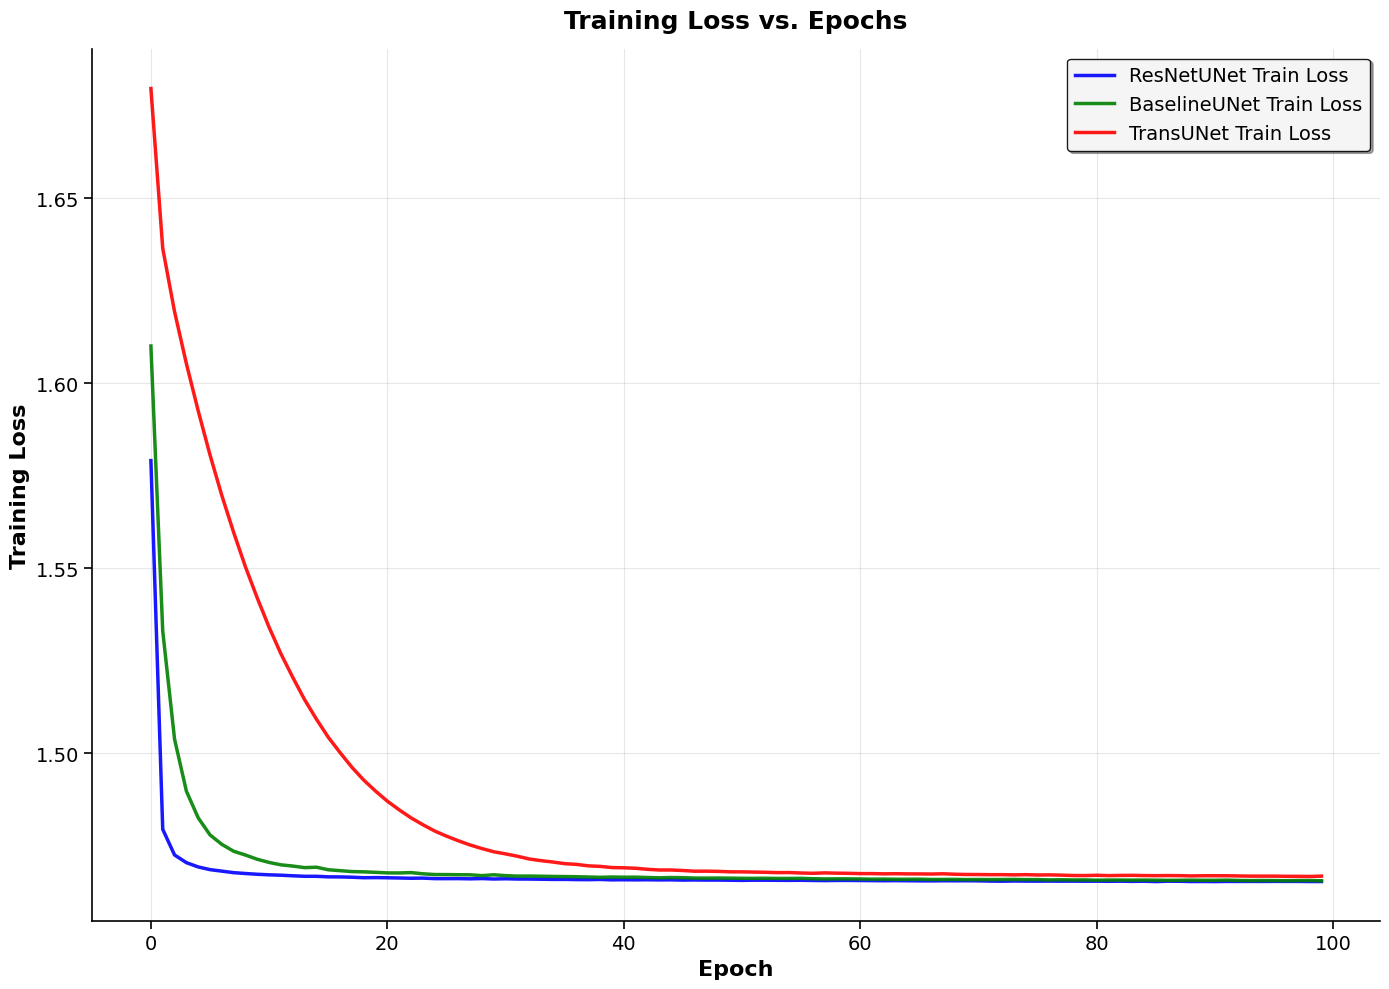

In [38]:
# --- Plot Comparison of Training Loss ---
fig, ax = plt.subplots(1, 1, figsize=(14, 10))

colors = {'ResNetUNet': 'blue', 'BaselineUNet': 'green', 'TransUNet': 'red'}

for model_name, results in all_results.items():
    ax.plot(results['history']['train_loss'], 
            label=f"{model_name} Train Loss", 
            color=colors.get(model_name),
            linewidth=2.5,
            alpha=0.9)

ax.set_title('Training Loss vs. Epochs', fontsize=18, fontweight='semibold', pad=15)
ax.set_xlabel('Epoch', fontsize=16, fontweight='semibold')
ax.set_ylabel('Training Loss', fontsize=16, fontweight='semibold')

# Enhanced legend
ax.legend(fontsize=14, frameon=True, fancybox=True, shadow=True, 
          framealpha=0.9, edgecolor='black', facecolor='white')

# Enhanced grid and ticks
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.8)
ax.tick_params(axis='both', which='major', labelsize=14, width=1.2, length=6)
ax.tick_params(axis='both', which='minor', width=0.8, length=4)

# Clean up the plot appearance
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

# Adjust layout
plt.tight_layout()

# --- Save the figure ---
loss_figure_path = os.path.join(FIGURES_DIR, 'all_models_loss_comparison.png')
plt.savefig(loss_figure_path, dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
print(f"Loss comparison plot saved to: {loss_figure_path}")
plt.show()

## 10. Tabular Summary of Test Scores
A table is perfect for presenting the final, definitive performance numbers. We'll use pandas to create a clean summary.

In [33]:
# --- Create the Final, Corrected Summary Table ---
summary_data = []
for model_name, score in final_scores.items():
    summary_data.append({
        'Model Architecture': model_name,
        'Final Test Dice Score (Corrected)': f"{score:.4f}",
        'Configuration': all_results[model_name]['config']
    })

summary_df = pd.DataFrame(summary_data).set_index('Model Architecture')

print("--- Final Project Performance Summary ---")
print(summary_df)

--- Final Project Performance Summary ---
                   Final Test Dice Score (Corrected)  \
Model Architecture                                     
ResNetUNet                                    0.9634   
BaselineUNet                                  0.5059   
TransUNet                                     0.0686   

                                       Configuration  
Model Architecture                                    
ResNetUNet          {'lr': 0.0001, 'batch_size': 16}  
BaselineUNet        {'lr': 0.0001, 'batch_size': 16}  
TransUNet             {'lr': 1e-05, 'batch_size': 8}  


## 11. Visualizing Predictions for Each Model
Finally, let's create side-by-side prediction visualizations for each model to provide qualitative proof of their performance.

--- Generating Final Comparative Prediction Figure ---
Loading model: ResNetUNet...
Loading model: BaselineUNet...
Loading model: TransUNet...
All models loaded successfully.


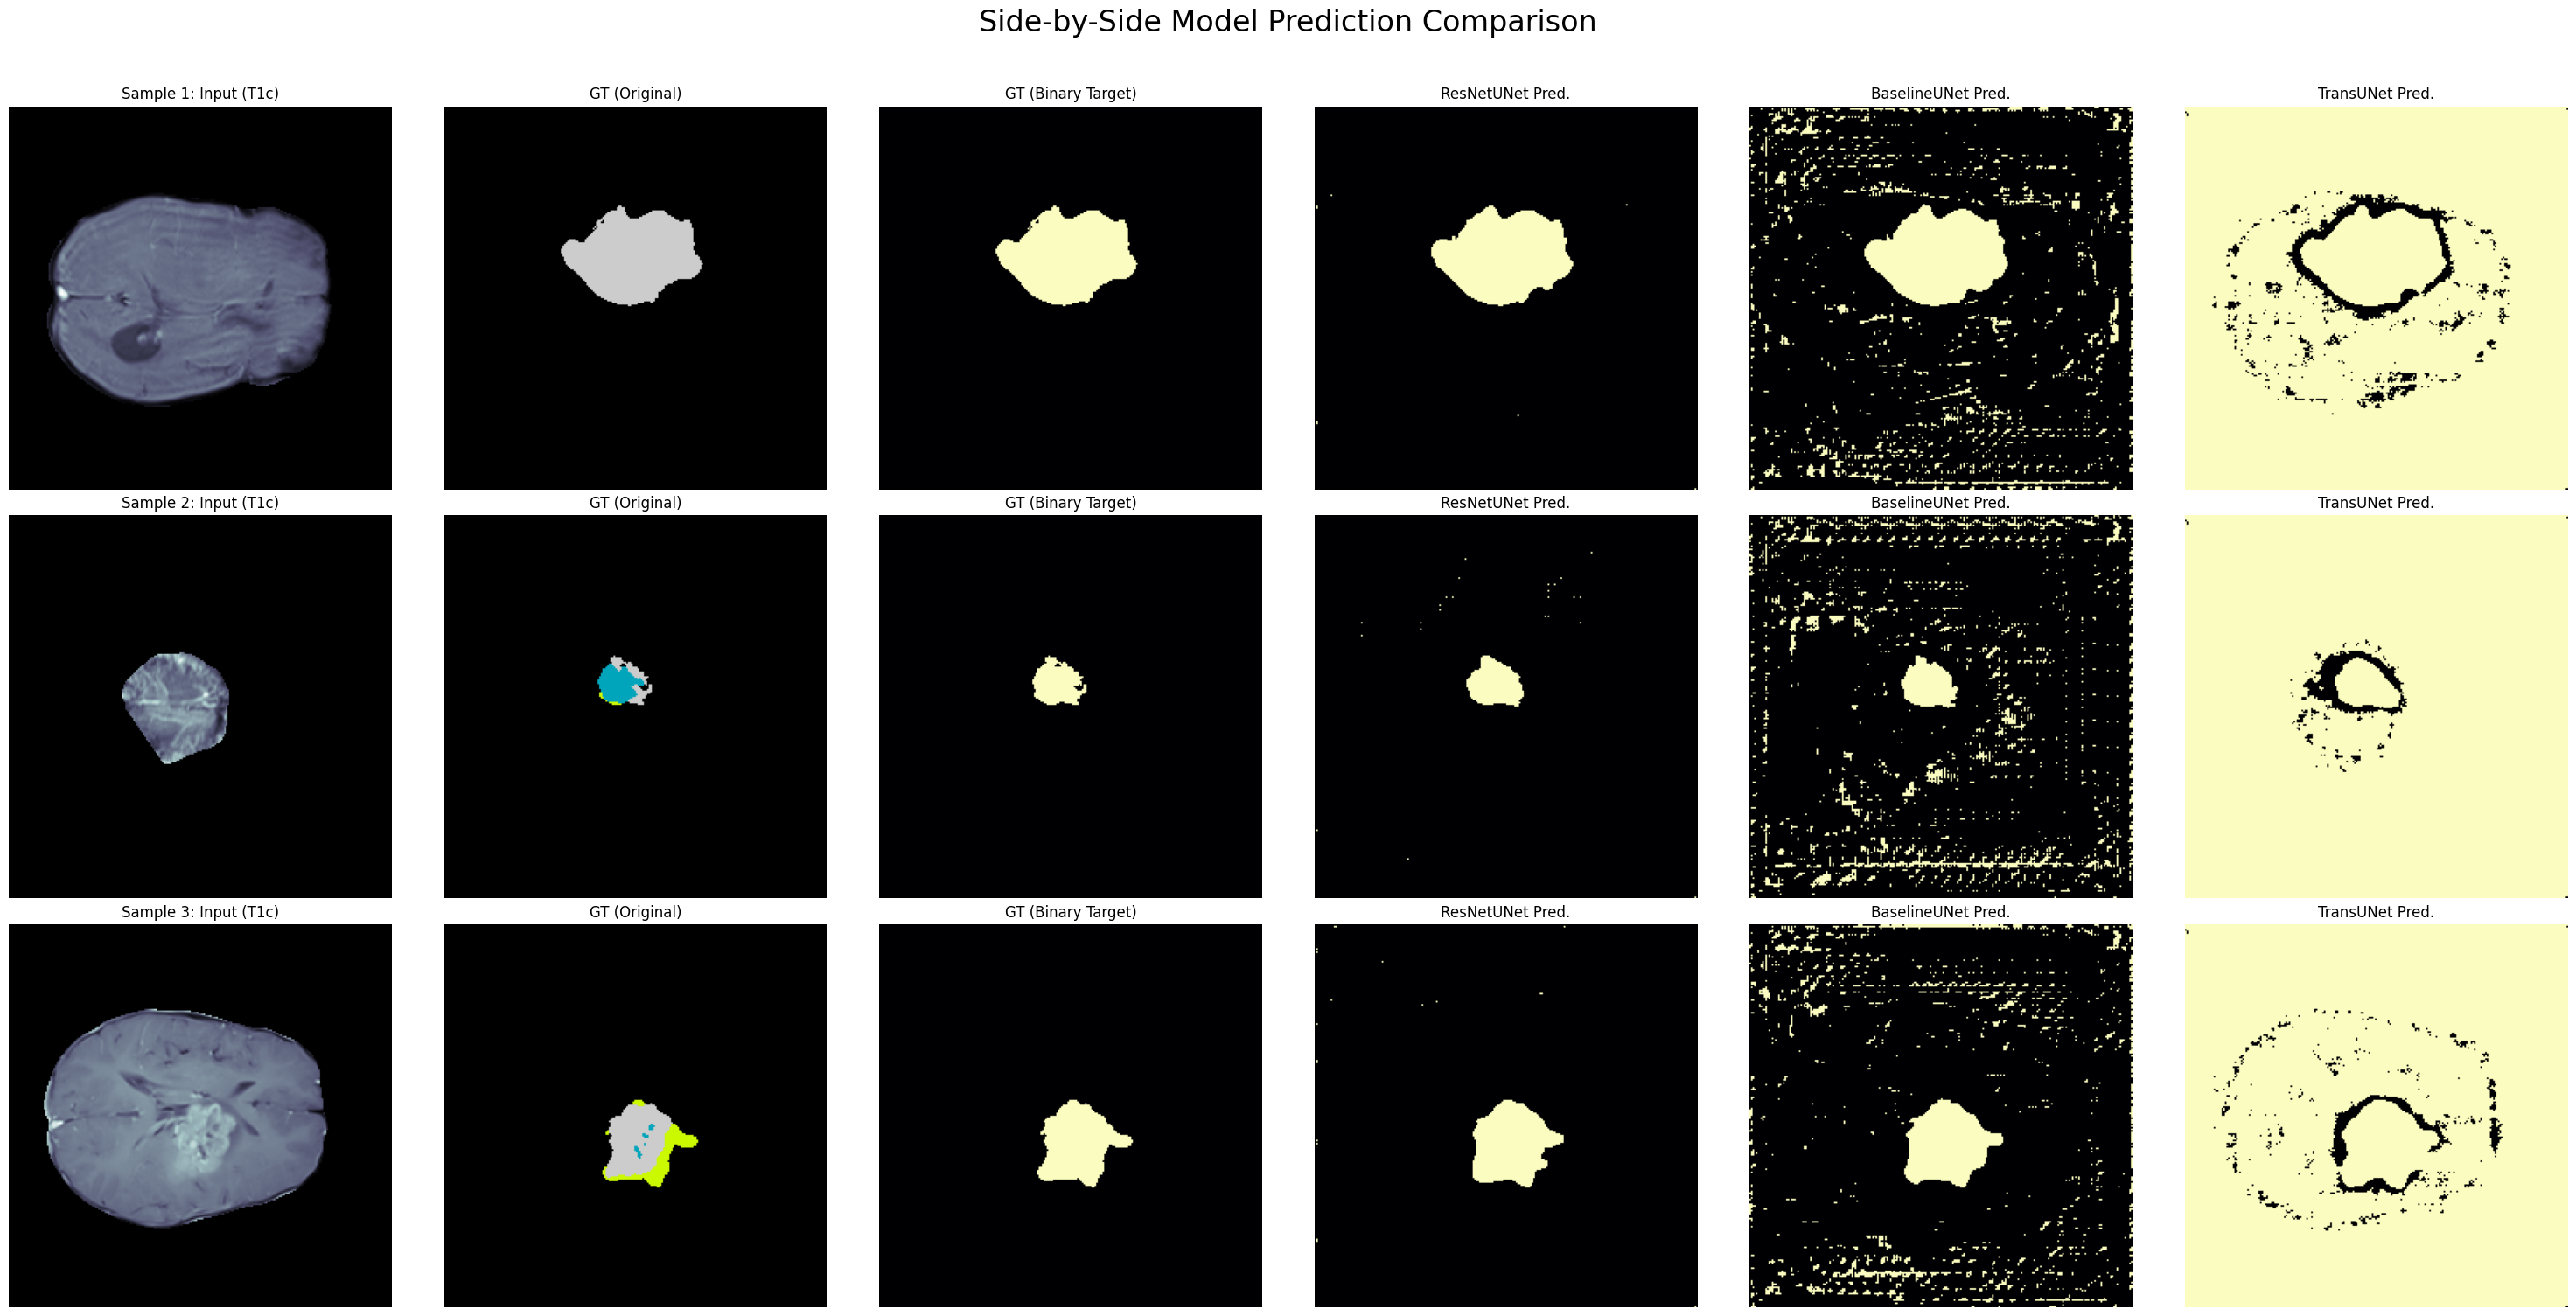


Final detailed comparison visualization saved to: D:\Coding\GitHub\MRI-Tumor-Segmentation\figures\final_prediction_comparison_detailed.png


In [34]:
# =========================================================================
#         FINAL COMPARATIVE VISUALIZATION OF PREDICTIONS (DEFINITIVE)
# =========================================================================

print("--- Generating Final Comparative Prediction Figure ---")

# --- 1. Load All Trained Models ---
models_to_load = list(all_results.keys())
loaded_models = {}

for model_name in models_to_load:
    print(f"Loading model: {model_name}...")
    if model_name == 'BaselineUNet': model = BaselineUNet(in_channels=4, out_channels=1).to(DEVICE)
    elif model_name == 'ResNetUNet': model = ResNetUNet(in_channels=4, out_channels=1).to(DEVICE)
    elif model_name == 'TransUNet': model = TransUNet(in_channels=4, out_channels=1).to(DEVICE)
    
    model.load_state_dict(torch.load(all_results[model_name]['model_path']))
    model.eval()
    loaded_models[model_name] = model

print("All models loaded successfully.")

# --- 2. Select 3 Random Test Samples ---
num_samples = 3
random_indices = random.sample(range(len(test_dataset)), num_samples)

# --- 3. Create the Comparison Plot ---
num_cols = 3 + len(models_to_load)
fig, axes = plt.subplots(num_samples, num_cols, figsize=(5 * num_cols, 5 * num_samples))
fig.suptitle('Side-by-Side Model Prediction Comparison', fontsize=24, y=1.0)

with torch.no_grad():
    for i, img_idx in enumerate(random_indices):
        image, original_mask = test_dataset[img_idx]
        binary_mask = (original_mask > 0).float()
        display_image = image.permute(1, 2, 0).numpy()[:, :, 0]
        
        axes[i, 0].imshow(display_image, cmap='bone'); axes[i, 0].set_title(f'Sample {i+1}: Input (T1c)'); axes[i, 0].axis('off')
        axes[i, 1].imshow(original_mask.squeeze(0).numpy(), cmap='nipy_spectral'); axes[i, 1].set_title(f'GT (Original)'); axes[i, 1].axis('off')
        axes[i, 2].imshow(binary_mask.squeeze(0).numpy(), cmap='magma'); axes[i, 2].set_title(f'GT (Binary Target)'); axes[i, 2].axis('off')
        
        for j, model_name in enumerate(models_to_load):
            model = loaded_models[model_name]
            pred_mask = (torch.sigmoid(model(image.unsqueeze(0).to(DEVICE))) > 0.5).float().cpu()
            axes[i, 3 + j].imshow(pred_mask.squeeze(0).squeeze(0).numpy(), cmap='magma'); axes[i, 3 + j].set_title(f'{model_name} Pred.'); axes[i, 3 + j].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.98])

# --- 4. Save the Final Figure ---
final_preds_fig_path = os.path.join(FIGURES_DIR, 'final_prediction_comparison_detailed.png')
plt.savefig(final_preds_fig_path, dpi=300, bbox_inches='tight'); plt.show()
print(f"\nFinal detailed comparison visualization saved to: {final_preds_fig_path}")

## End of Notebook 3

This concludes the model training and benchmarking phase. We have successfully:
- Trained one of our selected model architectures.
- Saved the best performing weights.
- Plotted the training history to analyze its learning behavior.
- Evaluated its final performance on the unseen test set.
- Visualized its segmentation capabilities on sample images.

To benchmark the other models, simply change the `MODEL_TO_TRAIN` variable at the top of this notebook and re-run all cells. Once all models are benchmarked, we will be ready to proceed to **Notebook 4: Inference and App Preparation**.

--- Generating Final Comparative Prediction Figure ---
Loading model: ResNetUNet...
Loading model: BaselineUNet...
Loading model: TransUNet...
All models loaded successfully.


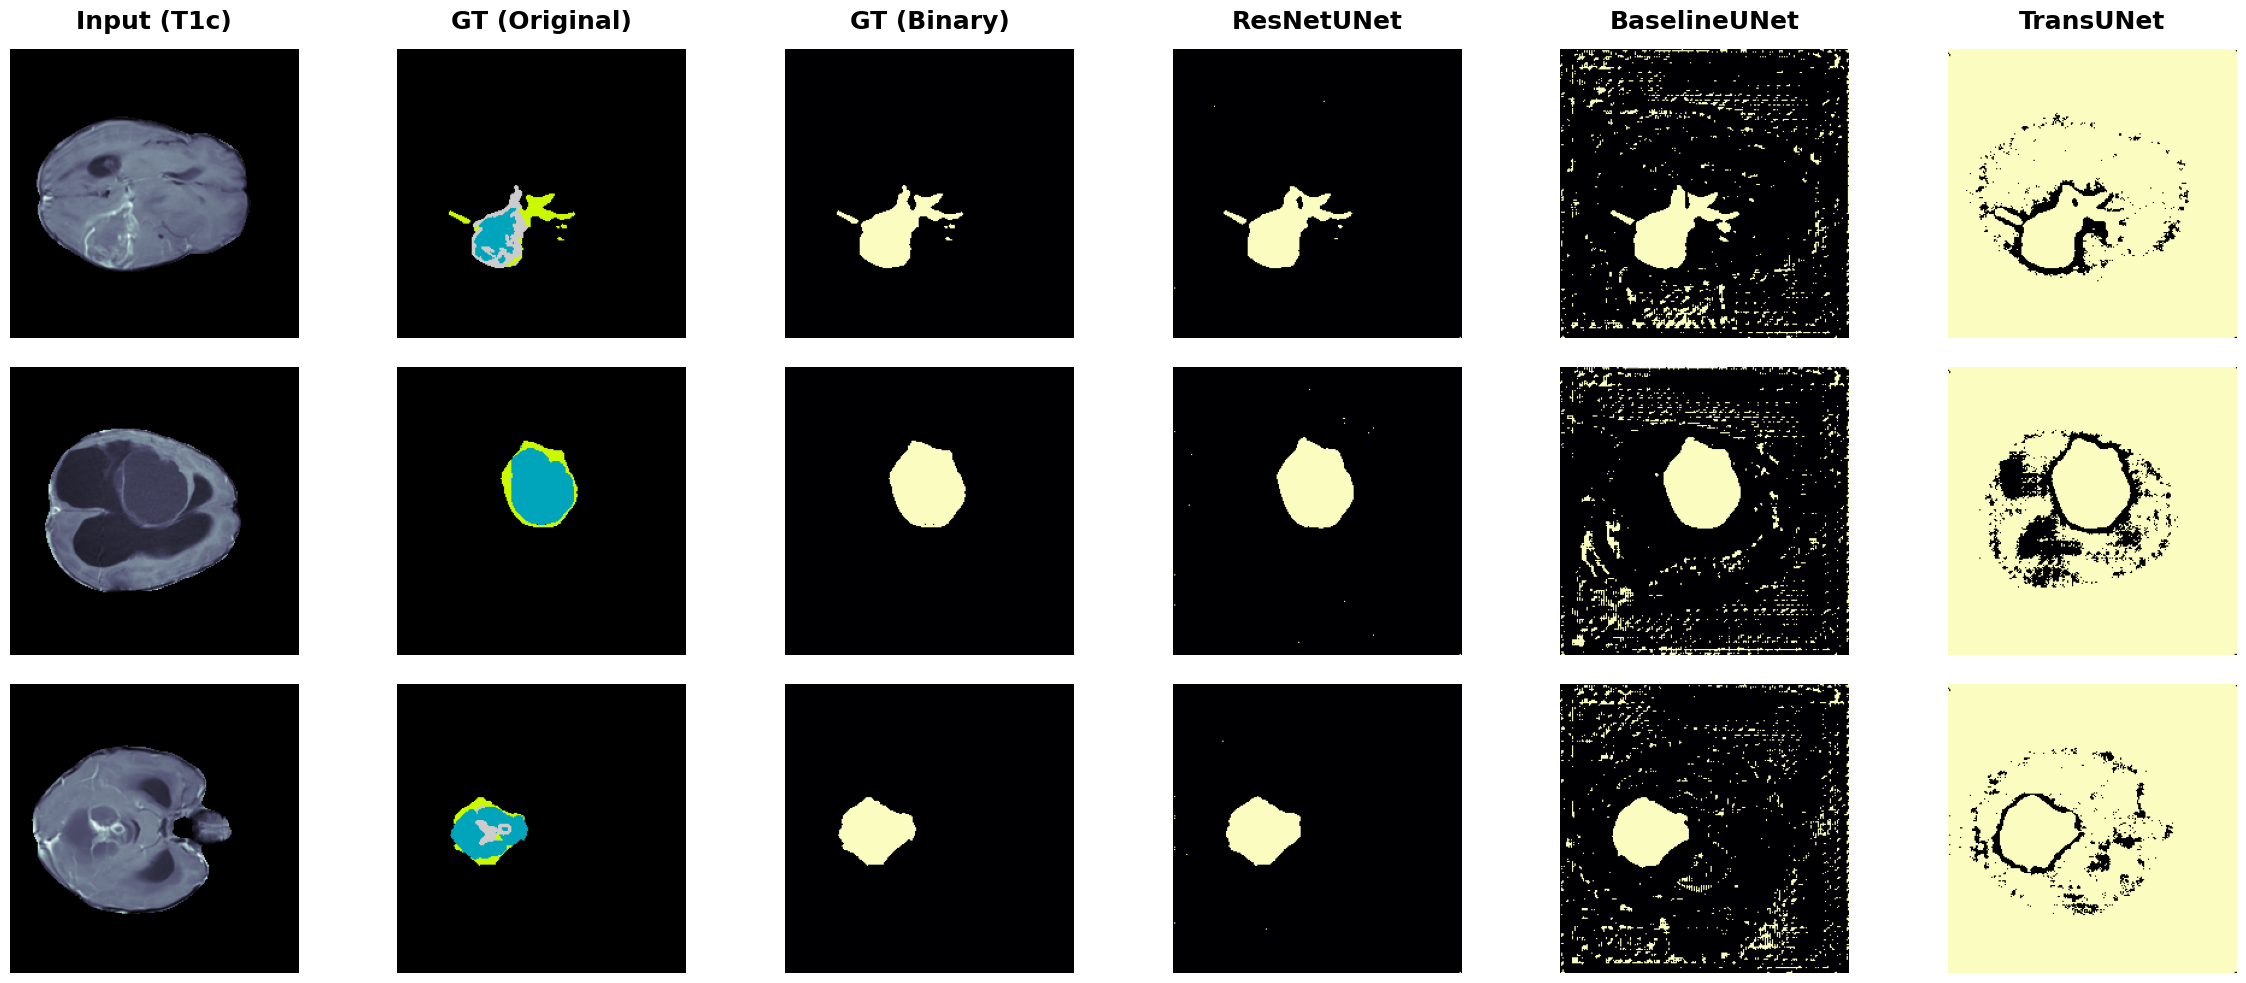


Final detailed comparison visualization saved to: D:\Coding\GitHub\MRI-Tumor-Segmentation\figures\final_prediction_comparison_detailed.png


In [59]:
# =========================================================================
#         FINAL COMPARATIVE VISUALIZATION OF PREDICTIONS (DEFINITIVE)
# =========================================================================

print("--- Generating Final Comparative Prediction Figure ---")

# --- 1. Load All Trained Models ---
models_to_load = list(all_results.keys())
loaded_models = {}

for model_name in models_to_load:
    print(f"Loading model: {model_name}...")
    if model_name == 'BaselineUNet': model = BaselineUNet(in_channels=4, out_channels=1).to(DEVICE)
    elif model_name == 'ResNetUNet': model = ResNetUNet(in_channels=4, out_channels=1).to(DEVICE)
    elif model_name == 'TransUNet': model = TransUNet(in_channels=4, out_channels=1).to(DEVICE)
    
    model.load_state_dict(torch.load(all_results[model_name]['model_path']))
    model.eval()
    loaded_models[model_name] = model

print("All models loaded successfully.")

# --- 2. Select 3 Random Test Samples ---
num_samples = 3
random_indices = random.sample(range(len(test_dataset)), num_samples)

# --- 3. Create the Enhanced Comparison Plot ---
num_cols = 3 + len(models_to_load)
fig, axes = plt.subplots(num_samples, num_cols, figsize=(5 * num_cols, 4 * num_samples))

# Add column titles only for the first row
column_titles = ['Input (T1c)', 'GT (Original)', 'GT (Binary)'] + [f'{name}' for name in models_to_load]
for j, title in enumerate(column_titles):
    axes[0, j].set_title(title, fontsize=18, fontweight='bold', pad=15)

# Add row labels
for i in range(num_samples):
    axes[i, 0].set_ylabel(f'Sample {i+1}', fontsize=16, fontweight='semibold', rotation=0, labelpad=40)

with torch.no_grad():
    for i, img_idx in enumerate(random_indices):
        image, original_mask = test_dataset[img_idx]
        binary_mask = (original_mask > 0).float()
        display_image = image.permute(1, 2, 0).numpy()[:, :, 0]
        
        # Clean visualization without individual titles
        axes[i, 0].imshow(display_image, cmap='bone')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(original_mask.squeeze(0).numpy(), cmap='nipy_spectral')
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(binary_mask.squeeze(0).numpy(), cmap='magma')
        axes[i, 2].axis('off')
        
        for j, model_name in enumerate(models_to_load):
            model = loaded_models[model_name]
            pred_mask = (torch.sigmoid(model(image.unsqueeze(0).to(DEVICE))) > 0.5).float().cpu()
            axes[i, 3 + j].imshow(pred_mask.squeeze(0).squeeze(0).numpy(), cmap='magma')
            axes[i, 3 + j].axis('off')

# Remove spacing between columns but keep spacing between rows
plt.subplots_adjust(wspace=0, hspace=0.1)

# --- 4. Save the Enhanced Figure ---
final_preds_fig_path = os.path.join(FIGURES_DIR, 'final_prediction_comparison_detailed.png')
plt.savefig(final_preds_fig_path, dpi=300, facecolor='white', edgecolor='none')
plt.show()
print(f"\nFinal detailed comparison visualization saved to: {final_preds_fig_path}")